Hello World!

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
import attila_utils
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
from bsmcalls import individuals
from bsmcalls import preprocessing
from bsmcalls import stats as bsmstats
import genome
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import graphics as smg
from statsmodels.graphics import regressionplots
from statsmodels.graphics import dotplots
import patsy
import scipy.stats as stats
import indiv_counts_modeling as icm
%matplotlib inline
import matplotlib
matplotlib.rcParams['text.usetex'] = False

## Preliminary
First we read in our annotated callset to the `data` DataFrame.  I import the schizophrenia GWAS genes too.

In [2]:
data = SNPnexus.load_data('../../results/2020-09-07-annotations/annotated-calls.p')
sczgwasloci = genome.read_scz_gwas()
data = genome.annotate_with_gwas_loci(data, gwas=sczgwasloci, modify_return_data=True)
clozukpath = '../../resources/CLOZUK/supp-table-4.csv'
gwasgenes = operations.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')

Next import psychiatric GWASets from the GWAS Catalog

In [3]:
fpath = '../2021-03-09-gwas-genes/selected-gwas.csv'
selgwas = pd.read_csv(fpath, index_col='Trait', sep='\t')
fpath = '../../resources/GWAS/gwas_catalog_v1.0.2-associations_e100_r2021-02-25.tsv'
gwas = pd.read_csv(fpath, sep='\t')
gwas = gwas.loc[gwas['PUBMEDID'].isin(selgwas['PMID']), :]

# get psychiatric GWASets
psychiatric_genesets = resources.gwascat_multi_genesets(gwas, selgwas.loc[selgwas['Trait type'] == 'psychiatric'])

psychiatric_reported = set()
psychiatric = set()
for k in psychiatric_genesets.keys():
    gset = psychiatric_genesets[k]
    if re.match('.*reported$$', k):
        psychiatric_reported.update(gset)
    else:
        psychiatric.update(gset)

psychiatric_genesets.update({'Psychiatric reported': psychiatric_reported, 'Psychiatric': psychiatric})
# remove reported gene sets
psychiatric_genesets = {k + ' GWAS': v for k, v in psychiatric_genesets.items() if not re.match('.*reported', k)}
# replace the GWAS Catalog's set of Schizophrenia GWAS with the geneset in Supp Table 4 of the CLOZUK paper
psychiatric_genesets['Schizophrenia GWAS'] = gwasgenes

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (9,11,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now import functional genesets implicated in schizophrenia by the PGC's study of rare variants!

In [4]:
fpath = '../../resources/rare-variants/41586_2014_BFnature12975_MOESM71_ESM.csv'
func_scz_genesets = pd.read_csv(fpath, sep='\t', index_col='Gene symbol').dropna().astype(pd.CategoricalDtype())
func_scz_genesets = func_scz_genesets.apply(lambda s: s.cat.rename_categories({'.': False, 'Y': True}), axis=1)
func_scz_genesets['composite'] = True
func_scz_genesets = {c: set(func_scz_genesets.index[func_scz_genesets[c]]) for c in func_scz_genesets}

Now import loss of function LoF constraints

In [5]:
tsvpath = '../../results/2021-02-24-gnomad-constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt'
constr = pd.read_csv(tsvpath, delimiter='\t', index_col=0)
constr['oe_lof < 0.35'] = constr.oe_lof < 0.35
genes_oe_lof = set(constr.index[constr['oe_lof < 0.35']])

Now the we query the annotated callset with a set of queries for annotations from `near_gens_Annotation` to `near_gens_Overlapped`.  This creates detailed `results` as well as a `summary` showing the number of calls in each category for each Dx.

### Note on enhancers

`Enh` stands for enhancer and `EnhG` for genic enhancer.  For the difference see [this discussion](https://www.biostars.org/p/211736/) summarized below:

> It's important to note that these are probabilistic categories based solely on the histone marks -- there are probably some promoters/TSS mixed in with the regions annotated as genic enhancers. 

In [6]:
genesets = dict()
genesets.update({'LoF intolerant genes': genes_oe_lof})
genesets.update(func_scz_genesets)
genesets.update(psychiatric_genesets)
sczloci = {'Schizophrenia GWAS loci': set([str(x) for x in list(sczgwasloci.Locus.sort_values().to_numpy())])}
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             #'ensembl_Predicted Function': ['coding'], # redundant (see 'coding nonsyn', 'coding syn')
             #'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'sift_Prediction': ['Deleterious'],
             #'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'polyphen_Prediction': ['Probably Damaging'],
             'tfbs_TFBS Name': None,
             'cpg_CpG Island': None,
             'ChromatinState_DLPFC': ['Enh', 'EnhG'],
             'phast_Score': None,
             'gerp_Element RS Score': None,
             #'near_gens_Overlapped Gene': {'SCZ GWAS': gwasgenes},
             'near_gens_Overlapped Gene': genesets,
             'SCZ GWAS locus, coding': sczloci,
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)
summary = operations.summarize_query_results(results, data, chisq=False, margin=False)
summary#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Dx                                                 Control  SCZ  ASD
Feature                   Query                                     
near_gens_Annotation      coding nonsyn                 23   43   23
                          coding syn                    16   20   15
                          missense                       0    0    0
                          stop-gain                      1    0    0
                          intronic (splice_site)         0    1    0
sift_Prediction           Deleterious                    8    9    6
polyphen_Prediction       Probably Damaging              3    5    2
tfbs_TFBS Name            any                           48   78   50
cpg_CpG Island            any                           26   47   19
ChromatinState_DLPFC      Enh                           53   77   56
                          EnhG                           5    7   10
phast_Score               any                          102  174  141
gerp_Element RS Score     any                          140  262  208
near_gens_Overlapped Gene LoF intolerant genes         410  667  531
                          PSD                           42   70   71
                          FMRP-target                   88  139  114
                          SCZ de novo                   43   69   69
                          Calcium channel                2    9    2
                          composite                    140  237  192
                          ADHD GWAS                      2    3    1
                          Anorexia nervosa GWAS          1    1    2
                          ASD GWAS                       2   20    7
                          Bipolar disorder GWAS         28   63   30
                          MDD GWAS                      13   27   22
                          Schizophrenia GWAS            20   66   42
                          Psychiatric GWAS              49  127   80
SCZ GWAS locus, coding    Schizophrenia GWAS loci        7   23   17

Repeat the operaton but excluding ASD individuals.

In [7]:
results_scz = operations.multiquery(querydict, preprocessing.drop_category(data, 'ASD'), do_sum=False, do_sort=False)
#results_scz['Dx'] = preprocessing.drop_category(data, 'ASD')['Dx'] # this in place modification is implicitly done in operations.summarize_query_results
summary_scz = operations.summarize_query_results(results_scz, preprocessing.drop_category(data, 'ASD'), chisq=False, margin=False)

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Detour: two closely related chi^2 tests

Here we look at two closely related ways of obtaining the expected counts for the chi^2 test.  For a given Dx the expected counts may be based on:
1. `ncalls` the number of calls across all individuals
1. `nsamples` the number of individuals

The comparison below shows that thet two methods yield similar results

In [8]:
def compare_ncalls_nsamples_chisq(data, results, summary):
    d = {'ncalls': data.groupby('Dx').size(), 'nsamples': individuals.get_nsamples(results)}
    dfd = {k: operations.chisquare_summary(summary, expected_odds, append=False) for k, expected_odds in d.items()}
    dfl = [pd.DataFrame(df.to_numpy(), columns=pd.MultiIndex.from_product([[k], df.columns]), index=df.index) for k, df in dfd.items()]
    df = pd.concat(dfl, axis=1)
    return((df, d))

df, ncalls_nsamples = compare_ncalls_nsamples_chisq(data, results, summary)
summary_chisq = df.xs('ncalls', axis=1) # for later use
df

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


ncalls            \
                                                  chisq stat   chisq p   
Feature                   Query                                          
near_gens_Annotation      coding nonsyn             4.480340  0.106440   
                          coding syn                1.177849  0.554924   
                          missense                       NaN       NaN   
                          stop-gain                 2.887477  0.236044   
                          intronic (splice_site)    1.582797  0.453210   
sift_Prediction           Deleterious               1.315056  0.518131   
polyphen_Prediction       Probably Damaging         1.080625  0.582566   
tfbs_TFBS Name            any                       4.120011  0.127453   
cpg_CpG Island            any                       9.614759  0.008169   
ChromatinState_DLPFC      Enh                       2.454611  0.293081   
                          EnhG                      0.953154  0.620905   
phast_Score               any                       1.591145  0.451323   
gerp_Element RS Score     any                       5.012216  0.081585   
near_gens_Overlapped Gene LoF intolerant genes      6.110077  0.047121   
                          PSD                       1.097207  0.577756   
                          FMRP-target               0.803238  0.669236   
                          SCZ de novo               0.623119  0.732304   
                          Calcium channel           5.154270  0.075991   
                          composite                 2.069647  0.355289   
                          ADHD GWAS                 0.934557  0.626706   
                          Anorexia nervosa GWAS     0.429823  0.806613   
                          ASD GWAS                 11.912735  0.002589   
                          Bipolar disorder GWAS     9.825898  0.007351   
                          MDD GWAS                  0.918933  0.631621   
                          Schizophrenia GWAS       10.800565  0.004515   
                          Psychiatric GWAS         13.492958  0.001175   
SCZ GWAS locus, coding    Schizophrenia GWAS loci   3.415481  0.181275   

                                                    nsamples            
                                                  chisq stat   chisq p  
Feature                   Query                                         
near_gens_Annotation      coding nonsyn             4.765326  0.092304  
                          coding syn                1.371564  0.503696  
                          missense                       NaN       NaN  
                          stop-gain                 2.950000  0.228779  
                          intronic (splice_site)    1.590164  0.451544  
sift_Prediction           Deleterious               1.451859  0.483875  
polyphen_Prediction       Probably Damaging         1.139182  0.565757  
tfbs_TFBS Name            any                       4.620352  0.099244  
cpg_CpG Island            any                      10.092813  0.006432  
ChromatinState_DLPFC      Enh                       2.953784  0.228346  
                          EnhG                      0.857319  0.651382  
phast_Score               any                       1.763406  0.414077  
gerp_Element RS Score     any                       4.990139  0.082491  
near_gens_Overlapped Gene LoF intolerant genes      7.613525  0.022220  
                          PSD                       0.786347  0.674912  
                          FMRP-target               1.103687  0.575887  
                          SCZ de novo               0.394908  0.820818  
                          Calcium channel           5.207000  0.074014  
                          composite                 2.338030  0.310673  
                          ADHD GWAS                 0.980568  0.612453  
                          Anorexia nervosa GWAS     0.406971  0.815882  
                          ASD GWAS                 11.954832  0.002535  
        

In [9]:
df, ncalls_nsamples_scz = compare_ncalls_nsamples_chisq(preprocessing.drop_category(data, 'ASD'), results_scz, summary_scz)
summary_chisq_scz = df.xs('ncalls', axis=1) # for later use
df

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


ncalls            \
                                                  chisq stat   chisq p   
Feature                   Query                                          
near_gens_Annotation      coding nonsyn             0.707206  0.400373   
                          coding syn                0.307556  0.579184   
                          missense                       NaN       NaN   
                          stop-gain                 1.505142  0.219882   
                          intronic (splice_site)    0.664389  0.415015   
sift_Prediction           Deleterious               0.361448  0.547703   
polyphen_Prediction       Probably Damaging         0.019501  0.888940   
tfbs_TFBS Name            any                       0.174529  0.676118   
cpg_CpG Island            any                       0.563172  0.452985   
ChromatinState_DLPFC      Enh                       0.039286  0.842884   
                          EnhG                      0.015302  0.901553   
phast_Score               any                       1.009212  0.315092   
gerp_Element RS Score     any                       4.346044  0.037095   
near_gens_Overlapped Gene LoF intolerant genes      1.535549  0.215282   
                          PSD                       0.273011  0.601319   
                          FMRP-target               0.125472  0.723174   
                          SCZ de novo               0.108609  0.741733   
                          Calcium channel           2.166917  0.141009   
                          composite                 1.217125  0.269926   
                          ADHD GWAS                 0.000014  0.997009   
                          Anorexia nervosa GWAS     0.084766  0.770940   
                          ASD GWAS                  8.717100  0.003152   
                          Bipolar disorder GWAS     3.175733  0.074740   
                          MDD GWAS                  0.917716  0.338075   
                          Schizophrenia GWAS        9.955066  0.001604   
                          Psychiatric GWAS         10.703282  0.001069   
SCZ GWAS locus, coding    Schizophrenia GWAS loci   3.440459  0.063618   

                                                    nsamples            
                                                  chisq stat   chisq p  
Feature                   Query                                         
near_gens_Annotation      coding nonsyn             0.624000  0.429565  
                          coding syn                0.352641  0.552622  
                          missense                       NaN       NaN  
                          stop-gain                 1.525000  0.216864  
                          intronic (splice_site)    0.655738  0.418069  
sift_Prediction           Deleterious               0.394986  0.529690  
polyphen_Prediction       Probably Damaging         0.014805  0.903155  
tfbs_TFBS Name            any                       0.119906  0.729136  
cpg_CpG Island            any                       0.485268  0.486046  
ChromatinState_DLPFC      Enh                       0.073799  0.785884  
                          EnhG                      0.021346  0.883841  
phast_Score               any                       0.808749  0.368490  
gerp_Element RS Score     any                       3.836963  0.050134  
near_gens_Overlapped Gene LoF intolerant genes      1.061274  0.302925  
                          PSD                       0.207275  0.648912  
                          FMRP-target               0.066556  0.796419  
                          SCZ de novo               0.068680  0.793268  
                          Calcium channel           2.110432  0.146298  
                          composite                 0.960560  0.327046  
                          ADHD GWAS                 0.000328  0.985553  
                          Anorexia nervosa GWAS     0.090369  0.763709  
                          ASD GWAS                  8.563413  0.003430  
        

['named-figure/ncall_nindiv_count-Dx.png',
 'named-figure/ncall_nindiv_count-Dx.pdf']

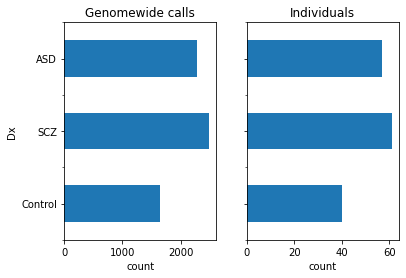

In [10]:
%matplotlib inline

def ncalls_nsamples_plot(ncalls_nsamples):
    fig, ax = plt.subplots(1, 2, sharey=True)
    ncalls_nsamples['ncalls'].plot(kind='barh', ax=ax[0])
    pd.Series(ncalls_nsamples['nsamples']).plot(kind='barh', ax=ax[1])
    ax[0].set_title('Genomewide calls')
    ax[1].set_title('Individuals')
    ax[0].set_xlabel('count')
    ax[1].set_xlabel('count')
    return((fig, ax))

fig, ax = ncalls_nsamples_plot(ncalls_nsamples)
attila_utils.savefig(fig, 'ncall_nindiv_count-Dx')

['named-figure/ncall_nindiv_count-Dx_scz.png',
 'named-figure/ncall_nindiv_count-Dx_scz.pdf']

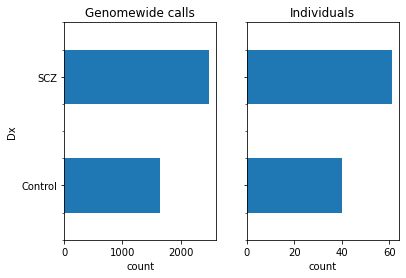

In [11]:
fig, ax = ncalls_nsamples_plot(ncalls_nsamples_scz)
attila_utils.savefig(fig, 'ncall_nindiv_count-Dx_scz')

## Limitations of the $\chi^2$ test

* univariate: it doesn't allow easy analysis of joint effects of multiple features
* counts of calls are the only possible variable to model

### Example: calls weighted by allele frequency

This piece of analysis shows that weighting each call with its allele frequency decreases significance of the $\chi^2$ test since the $\mathrm{AF} < 1$ (moreover $\mathrm{AF} \ll 1$ for most calls).

In [12]:
wncalls = data.groupby('Dx')['AF'].sum()
#wresults = results.drop(('Dx', ), axis=1).astype('int16').apply(lambda x: x * data['AF'], axis=0)
operations.chisquare_summary(summary, expected_odds=wncalls, append=False)

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


chisq stat   chisq p
Feature                   Query                                        
near_gens_Annotation      coding nonsyn              1.152128  0.562107
                          coding syn                 0.491868  0.781974
                          missense                        NaN       NaN
                          stop-gain                  2.675849  0.262390
                          intronic (splice_site)     1.330329  0.514189
sift_Prediction           Deleterious                0.673078  0.714238
polyphen_Prediction       Probably Damaging          0.472640  0.789528
tfbs_TFBS Name            any                        0.209300  0.900640
cpg_CpG Island            any                        4.093641  0.129145
ChromatinState_DLPFC      Enh                        0.216342  0.897474
                          EnhG                       2.578216  0.275516
phast_Score               any                        3.446117  0.178519
gerp_Element RS Score     any                        7.684747  0.021443
near_gens_Overlapped Gene LoF intolerant genes       7.794576  0.020297
                          PSD                        7.010552  0.030038
                          FMRP-target                2.048871  0.358999
                          SCZ de novo                5.870027  0.053130
                          Calcium channel            3.680429  0.158783
                          composite                  4.462185  0.107411
                          ADHD GWAS                  0.503790  0.777326
                          Anorexia nervosa GWAS      0.847928  0.654447
                          ASD GWAS                   9.303717  0.009544
                          Bipolar disorder GWAS      4.146171  0.125797
                          MDD GWAS                   1.543196  0.462274
                          Schizophrenia GWAS         8.908390  0.011630
                          Psychiatric GWAS           8.954870  0.011363
SCZ GWAS locus, coding    Schizophrenia GWAS loci    3.637566  0.162223

The same without ASD samples

In [13]:
wncalls_scz = preprocessing.drop_category(data, 'ASD').groupby('Dx')['AF'].sum()
operations.chisquare_summary(summary_scz, expected_odds=wncalls_scz, append=False)

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


chisq stat   chisq p
Feature                   Query                                        
near_gens_Annotation      coding nonsyn              0.433755  0.510152
                          coding syn                 0.483215  0.486970
                          missense                        NaN       NaN
                          stop-gain                  1.577395  0.209136
                          intronic (splice_site)     0.633957  0.425908
sift_Prediction           Deleterious                0.488456  0.484617
polyphen_Prediction       Probably Damaging          0.005684  0.939903
tfbs_TFBS Name            any                        0.026271  0.871239
cpg_CpG Island            any                        0.311360  0.576847
ChromatinState_DLPFC      Enh                        0.212548  0.644778
                          EnhG                       0.041562  0.838456
phast_Score               any                        0.394524  0.529931
gerp_Element RS Score     any                        2.672295  0.102109
near_gens_Overlapped Gene LoF intolerant genes       0.241809  0.622902
                          PSD                        0.079574  0.777876
                          FMRP-target                0.000100  0.992020
                          SCZ de novo                0.007775  0.929735
                          Calcium channel            1.969098  0.160544
                          composite                  0.439396  0.507414
                          ADHD GWAS                  0.003038  0.956045
                          Anorexia nervosa GWAS      0.105676  0.745122
                          ASD GWAS                   8.176922  0.004243
                          Bipolar disorder GWAS      2.470898  0.115972
                          MDD GWAS                   0.668354  0.413626
                          Schizophrenia GWAS         8.749691  0.003097
                          Psychiatric GWAS           8.900073  0.002852
SCZ GWAS locus, coding    Schizophrenia GWAS loci    3.021848  0.082150

## DataFrame for regression: `fitdata`

First get rid of `SCZ GWAS locus, coding` since it is redundant given `Schizophrenia GWAS genes`

In [14]:
results = results.drop('SCZ GWAS locus, coding', axis=1, level=0)
results_scz = results_scz.drop('SCZ GWAS locus, coding', axis=1, level=0)
summary = summary.drop('SCZ GWAS locus, coding', axis=0, level=0)
summary_scz = summary_scz.drop('SCZ GWAS locus, coding', axis=0, level=0)
summary_chisq = summary_chisq.drop('SCZ GWAS locus, coding', axis=0, level=0)
summary_chisq_scz = summary_chisq_scz.drop('SCZ GWAS locus, coding', axis=0, level=0)

Now prepare data for fitting models

In [15]:
selcols = ['DP', 'BaseQRankSum', 'AF']
selcols_indiv = ['Dx', 'ageOfDeath', 'Dataset', 'Reported Gender']
#prettynames = ['coding nonsyn', 'coding syn', 'missense', 'stop gain', 'splice site', 'coding', 'deleterious (sift)', 'damaging (polyphen)', 'TFBS', 'CpG island', 'enhancer', 'genic enhancer', 'evolutionary cons. (phast)', 'evolutionary cons. (gerp)']
prettynames = ['coding nonsyn', 'coding syn', 'missense', 'stop gain', 'splice site', 'deleterious (sift)', 'damaging (polyphen)', 'TFBS', 'CpG island', 'enhancer', 'genic enhancer', 'evolutionary cons. (phast)', 'evolutionary cons. (gerp)']
prettynames += list(summary.xs('near_gens_Overlapped Gene', 0).index) # add GWASets

def get_fitdata(data, results):
    covariates = data[selcols].groupby('Individual ID').mean()
    covariates[selcols_indiv] = data[selcols_indiv].groupby('Individual ID').first()
    covariates = covariates.rename({'Reported Gender': 'Gender'}, axis=1)
    covariates['ncalls'] = data.groupby('Individual ID').size()
    covariates = pd.concat([covariates, covariates['ncalls'].apply(np.log10).rename('log10_ncalls')], axis=1)
    Dxs = pd.Categorical(results[('Dx', )].groupby('Individual ID').first(), categories=results[('Dx', )].cat.categories)
    responses = results.drop(('Dx',), axis=1).groupby('Individual ID').sum()
    responses.columns = prettynames
    responses_prop = responses.apply(lambda x: x / covariates['ncalls'], axis=0).rename(lambda x: 'prop_' + x, axis=1)
    fitdata = pd.concat([responses, covariates], axis=1)
    return((fitdata, covariates, responses, responses_prop))

fitdata, covariates, responses, responses_prop = get_fitdata(data, results)
fitdata_scz, covariates_scz, responses_scz, responses_prop_scz = get_fitdata(preprocessing.drop_category(data, 'ASD'), results_scz)

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


### Pairwise joint distributions

* No two variables show extremely tight dependence which implies limited collinearity in a normal or generalized linear model.
* The fraction of calls `fcalls_scz_gwas_genes` has very high variance when the total number of calls for an individual is low. This is undesirable.

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


['named-figure/symmetric-scatter-matrix.png',
 'named-figure/symmetric-scatter-matrix.pdf']

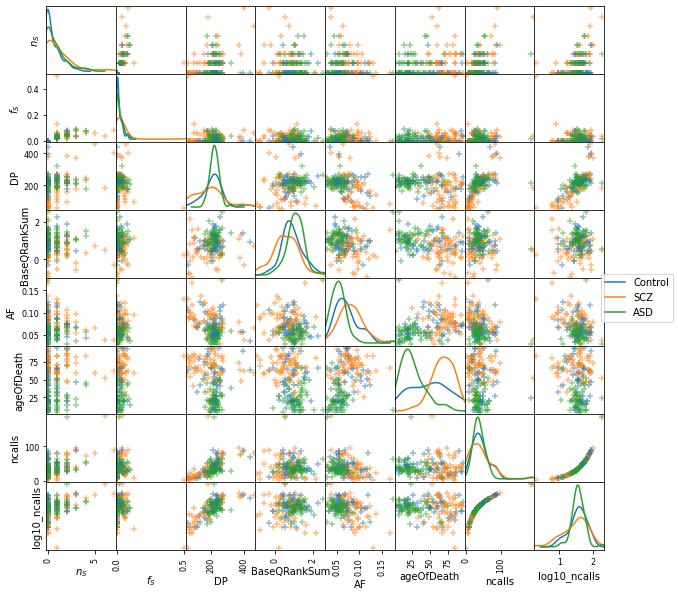

In [16]:
def scatter_matrix_plot(responses, responses_prop, covariates):
    df = pd.concat([responses['Schizophrenia GWAS'], responses_prop['prop_Schizophrenia GWAS'], covariates], axis=1)
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = df.Dx.cat.rename_categories({'Control': 'C0', 'SCZ': 'C1', 'ASD': 'C2'})
    ax = pd.plotting.scatter_matrix(df, ax=ax, color=colors, diagonal='kde', marker='+')
    dfnum = df.select_dtypes('number').copy()
    for i in range(ax.shape[0]):
        axi = ax[i][i]
        axi.lines.clear()
        for Dx, color in zip(df.Dx.cat.categories, ['C0', 'C1', 'C2']):
            d = dfnum.loc[df.Dx == Dx].iloc[:, i]
            d.plot(kind='kde', color=color, ax=axi)
            axi.set_ylabel('')
            axi.set_yticks([])
    axi = ax[0][0]
    axi.set_ylabel('$n_S$')
    axi = ax[-1][0]
    axi.set_xlabel('$n_S$')
    axi.set_yticks([])
    axi = ax[1][0]
    axi.set_ylabel('$f_S$')
    axi = ax[-1][1]
    axi.set_xlabel('$f_S$')
    fig.legend(ax[0][0].lines, df.Dx.cat.categories, loc='center right')
    return((fig, ax))

fig, ax = scatter_matrix_plot(responses, responses_prop, covariates)
attila_utils.savefig(fig, 'symmetric-scatter-matrix')

The same plot without ASD samples

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


['named-figure/symmetric-scatter-matrix_scz.png',
 'named-figure/symmetric-scatter-matrix_scz.pdf']

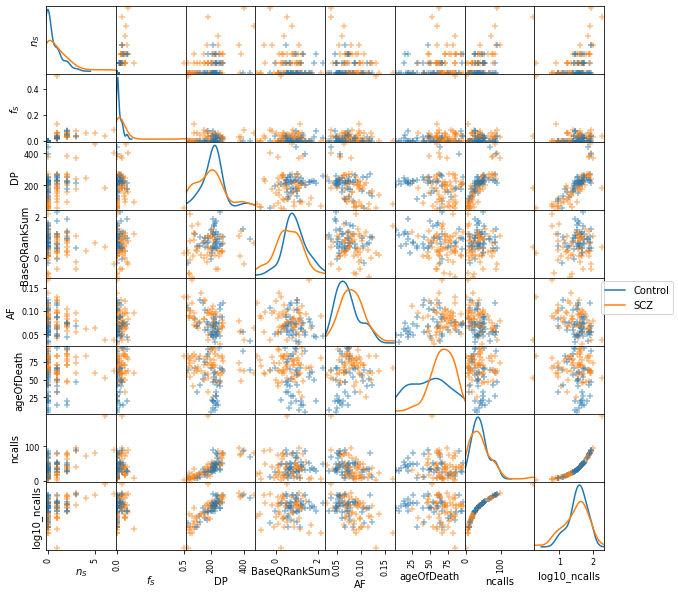

In [17]:
fig, ax = scatter_matrix_plot(responses_scz, responses_prop_scz, covariates_scz)
attila_utils.savefig(fig, 'symmetric-scatter-matrix_scz')

['named-figure/ncalls-scz_gwas_gene-ncalls.png',
 'named-figure/ncalls-scz_gwas_gene-ncalls.pdf']

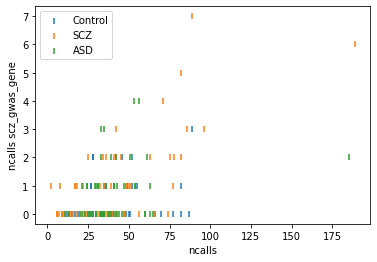

In [18]:
fig, ax = plt.subplots()
for Dx in ['Control', 'SCZ', 'ASD']:
    ax.scatter(x='ncalls', y='Schizophrenia GWAS', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', label=Dx)
ax.legend()
ax.set_xlabel('ncalls')
ax.set_ylabel('ncalls scz_gwas_gene')
attila_utils.savefig(fig, 'ncalls-scz_gwas_gene-ncalls')

## Multiple functional categories
### Response: ncalls in functional categ

Here the response (endogenous or dependent variable) is the number of calls per individual in some functinal category, and is plotted on the y axis.

The genome-wide number of calls per individual (`ncalls` or `log10_ncalls`) is regarded as an explanatory variable, and is plotted on the x axis.

['named-figure/ncalls-func-categ-predictors.png',
 'named-figure/ncalls-func-categ-predictors.pdf']

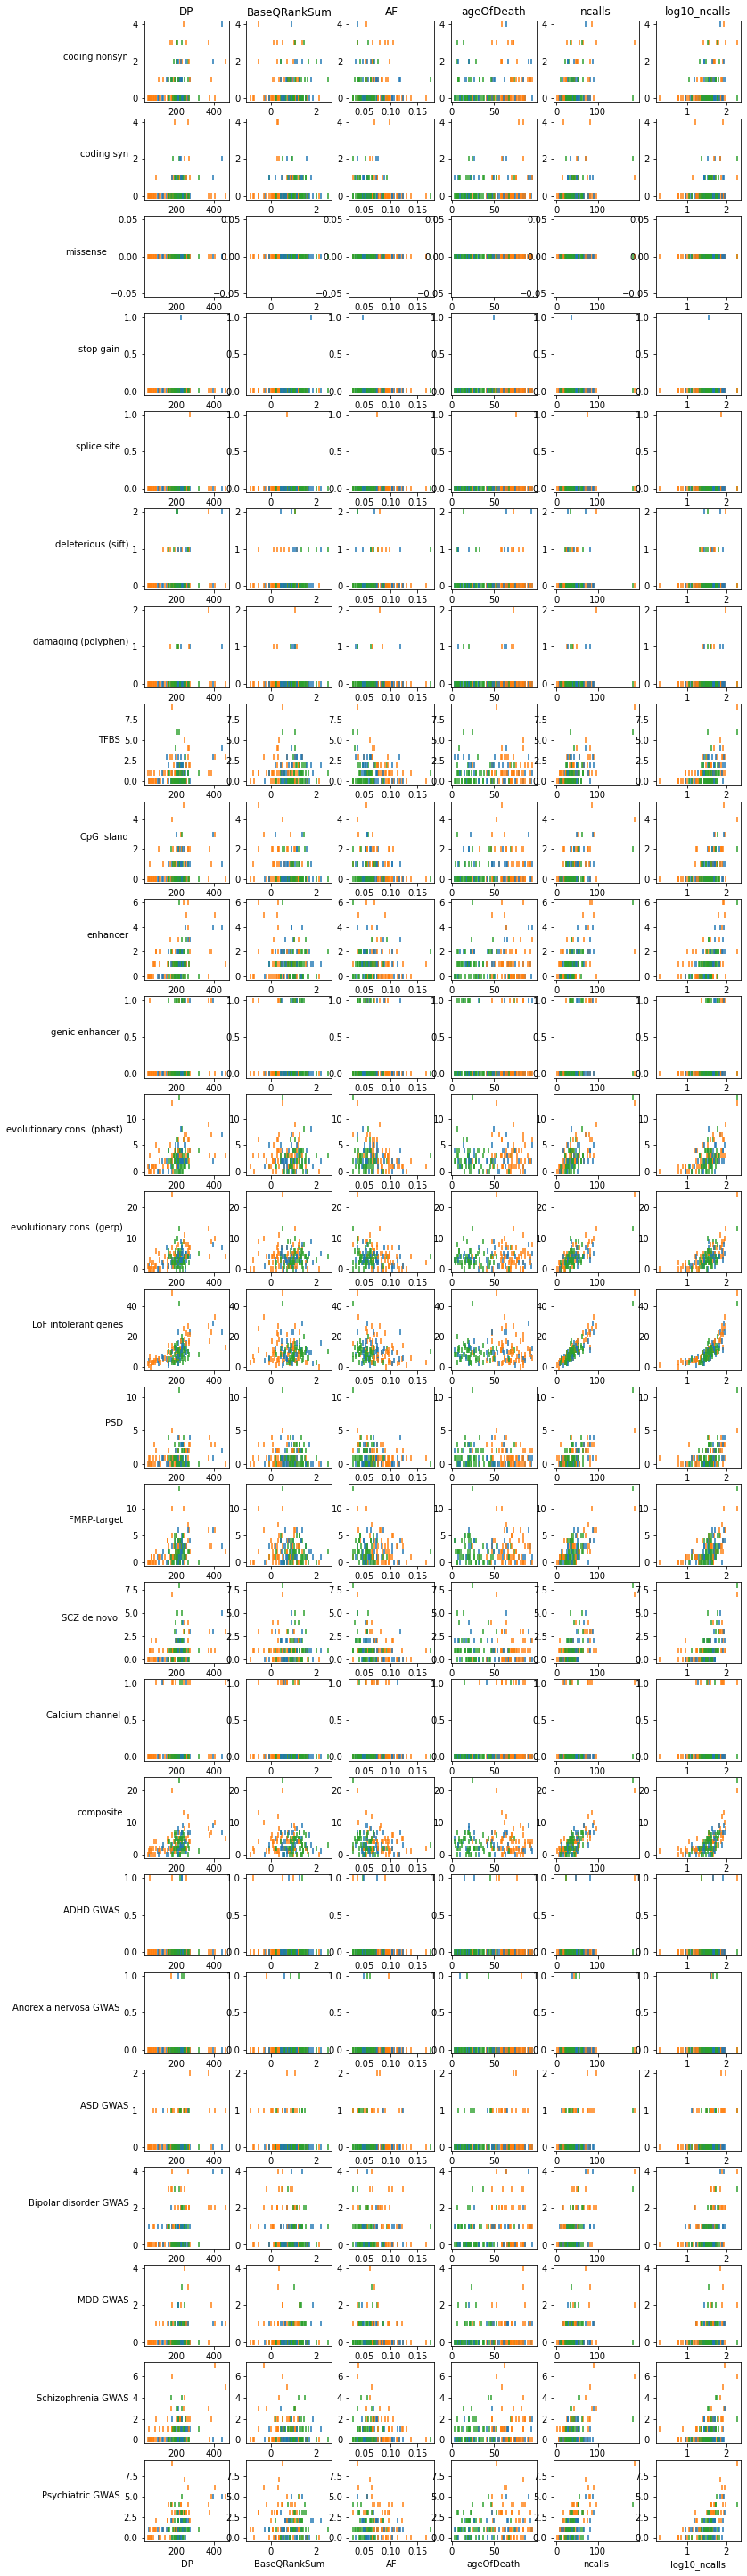

In [19]:
def getDxcol(fitdata):
    Dxs = fitdata['Dx'].copy()
    l = ['C' + str(x) for x in range(len(Dxs.cat.categories))]
    Dxcol = Dxs.cat.rename_categories(l)
    return(Dxcol)

def ncalls_categ_predictors_plot(fitdata, responses, covariates):
    Dxcol = getDxcol(fitdata)
    fig, ax = icm.big_plot_matrix(responses, covariates, Dxcol)
    return((fig, ax))

fig, ax = ncalls_categ_predictors_plot(fitdata, responses, covariates)
attila_utils.savefig(fig, 'ncalls-func-categ-predictors')

Repeat without the ASD individuals

['named-figure/ncalls-func-categ-predictors_scz.png',
 'named-figure/ncalls-func-categ-predictors_scz.pdf']

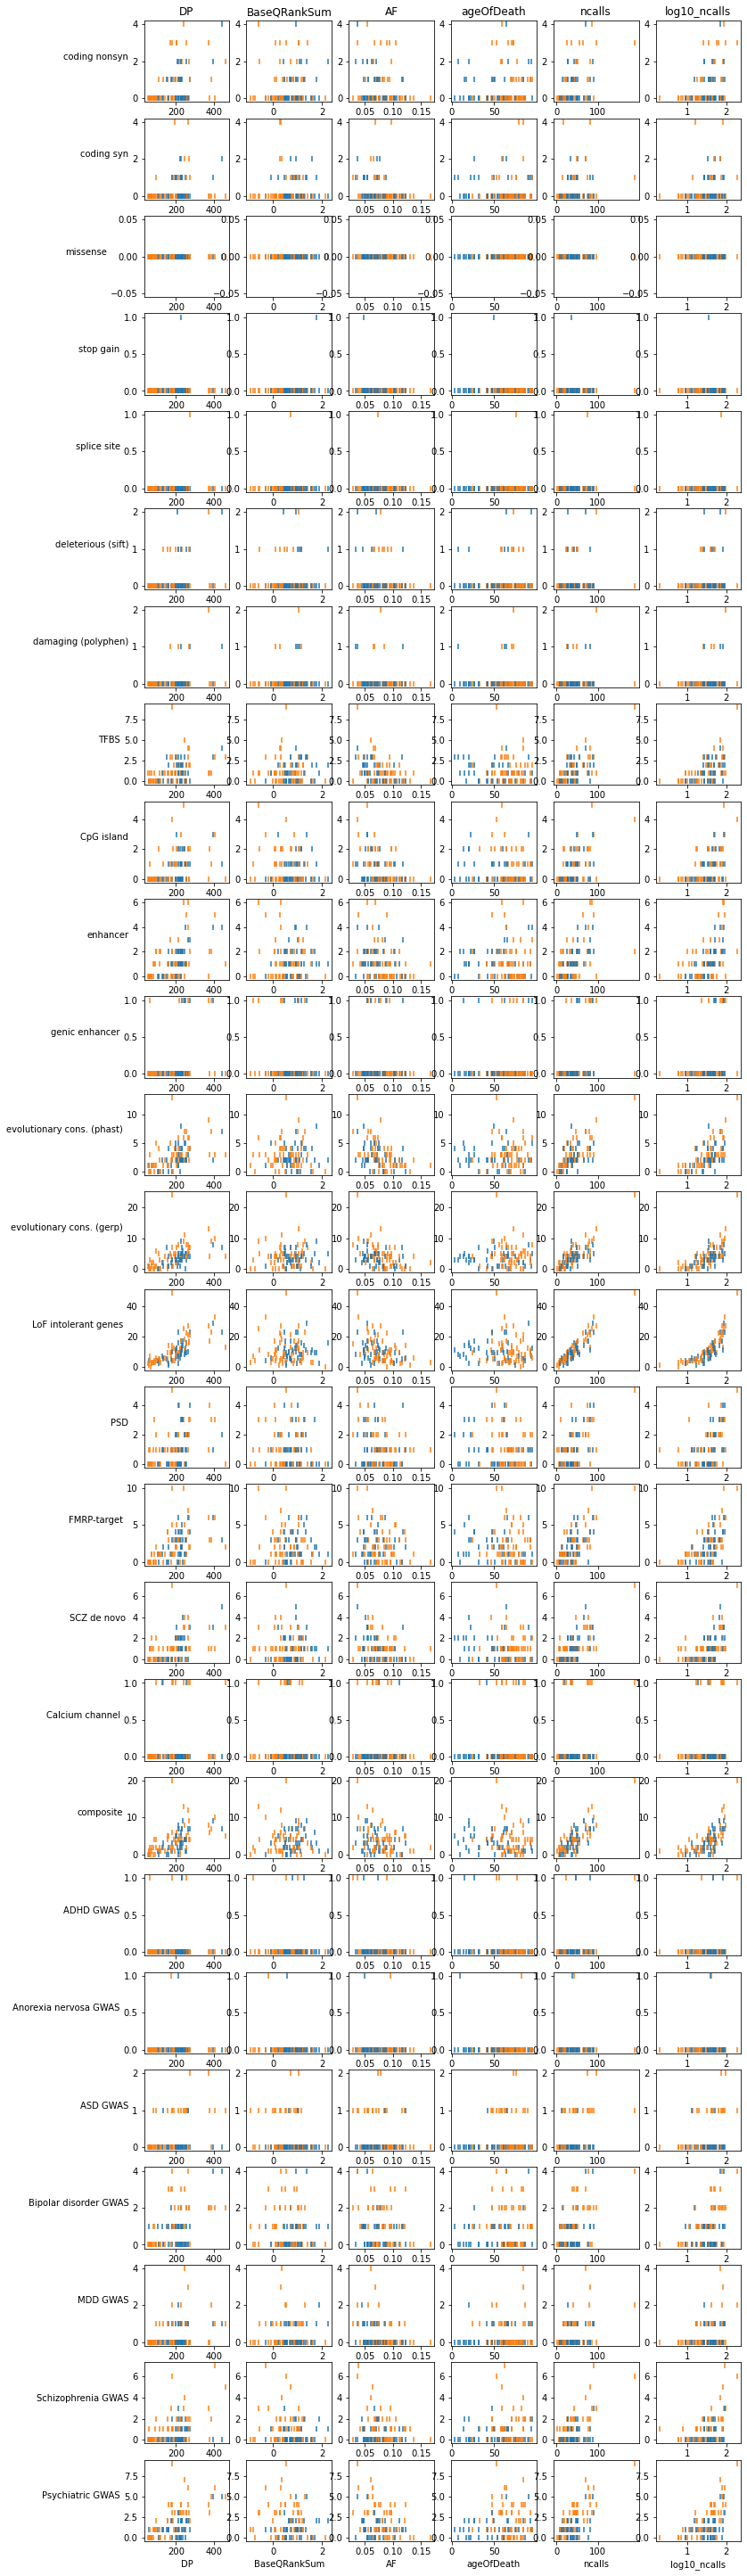

In [20]:
fig, ax = ncalls_categ_predictors_plot(fitdata_scz, responses_scz, covariates_scz)
attila_utils.savefig(fig, 'ncalls-func-categ-predictors_scz')

### More transformations

['named-figure/DP-AF-log10-transform.png',
 'named-figure/DP-AF-log10-transform.pdf']

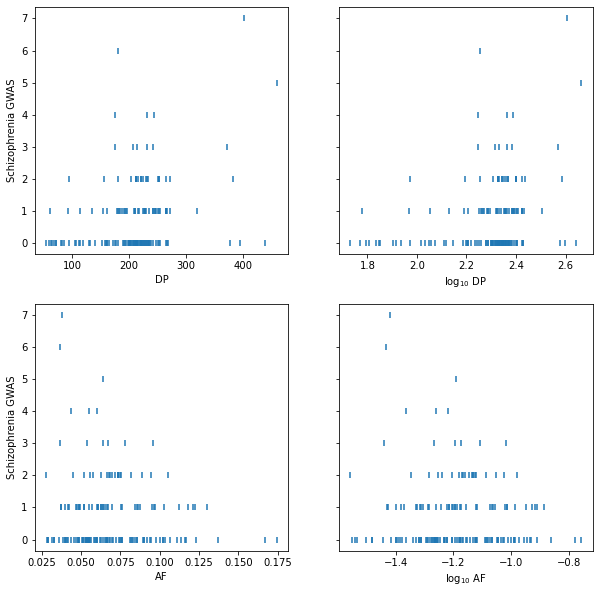

In [21]:
%matplotlib inline

def more_transform_plot(responses, covariates):
    features = ['DP', 'AF']
    fig, ax = plt.subplots(len(features), 2, figsize=(10, 10), sharey=True)
    for i, feature in zip(range(len(features)), features):
        ax[i, 0].scatter(y=responses['Schizophrenia GWAS'], x=covariates[feature], marker='|')
        ax[i, 0].set_ylabel('Schizophrenia GWAS')
        ax[i, 0].set_xlabel(feature)
        ax[i, 1].scatter(y=responses['Schizophrenia GWAS'], x=np.log10(covariates[feature]), marker='|')
        ax[i, 1].set_xlabel('$\log_{10}$ ' + feature)
    return((fig, ax))

fig, ax = more_transform_plot(responses, covariates)
attila_utils.savefig(fig, 'DP-AF-log10-transform')

Now without the ASD individuals

['named-figure/DP-AF-log10-transform_scz.png',
 'named-figure/DP-AF-log10-transform_scz.pdf']

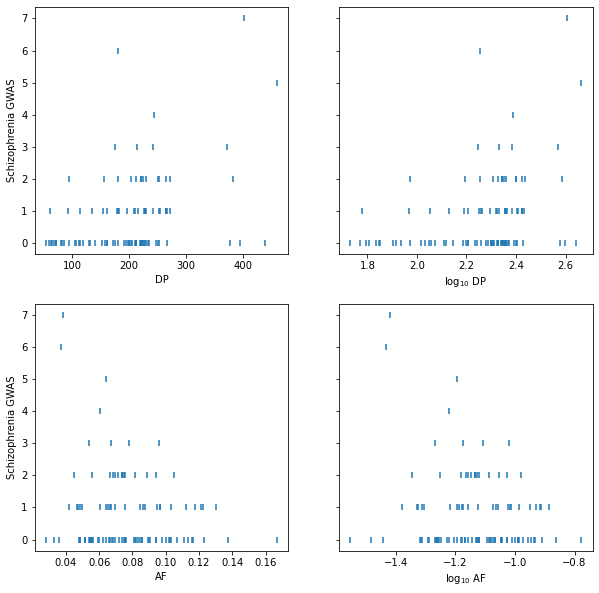

In [22]:
fig, ax = more_transform_plot(responses_scz, covariates_scz)
attila_utils.savefig(fig, 'DP-AF-log10-transform_scz')

### Response: proportion of calls in func categ

In this case we take the proportion, for each individual, of the following two counts:
1. the number calls in some functional category and
1. the genome wide number of calls

The advantage of this definition of response over the previous one is that now we directly condition the first variable on the second for each individual.

['named-figure/prop_calls-func-categ-predictors.png',
 'named-figure/prop_calls-func-categ-predictors.pdf']

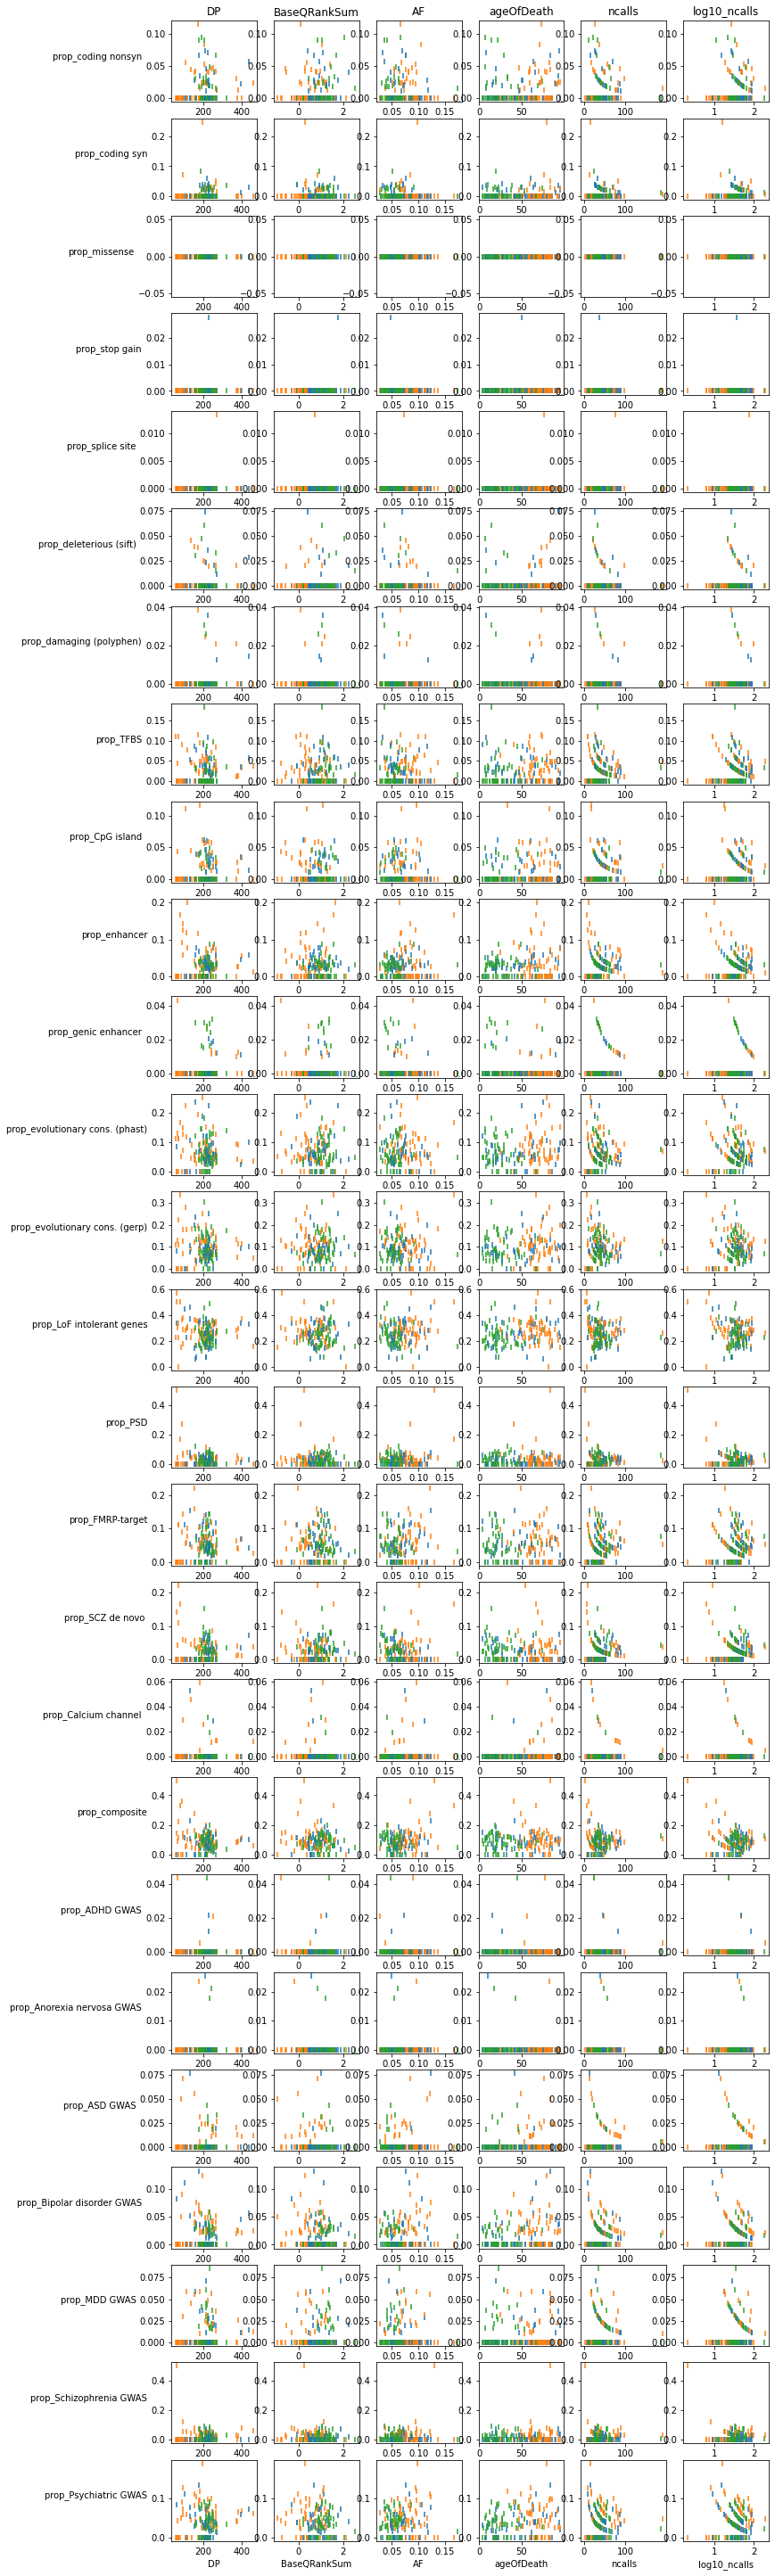

In [23]:
fig, ax = icm.big_plot_matrix(responses_prop, covariates, getDxcol(fitdata))
attila_utils.savefig(fig, 'prop_calls-func-categ-predictors')

Repeat without the ASD individuals

['named-figure/prop_calls-func-categ-predictors_scz.png',
 'named-figure/prop_calls-func-categ-predictors_scz.pdf']

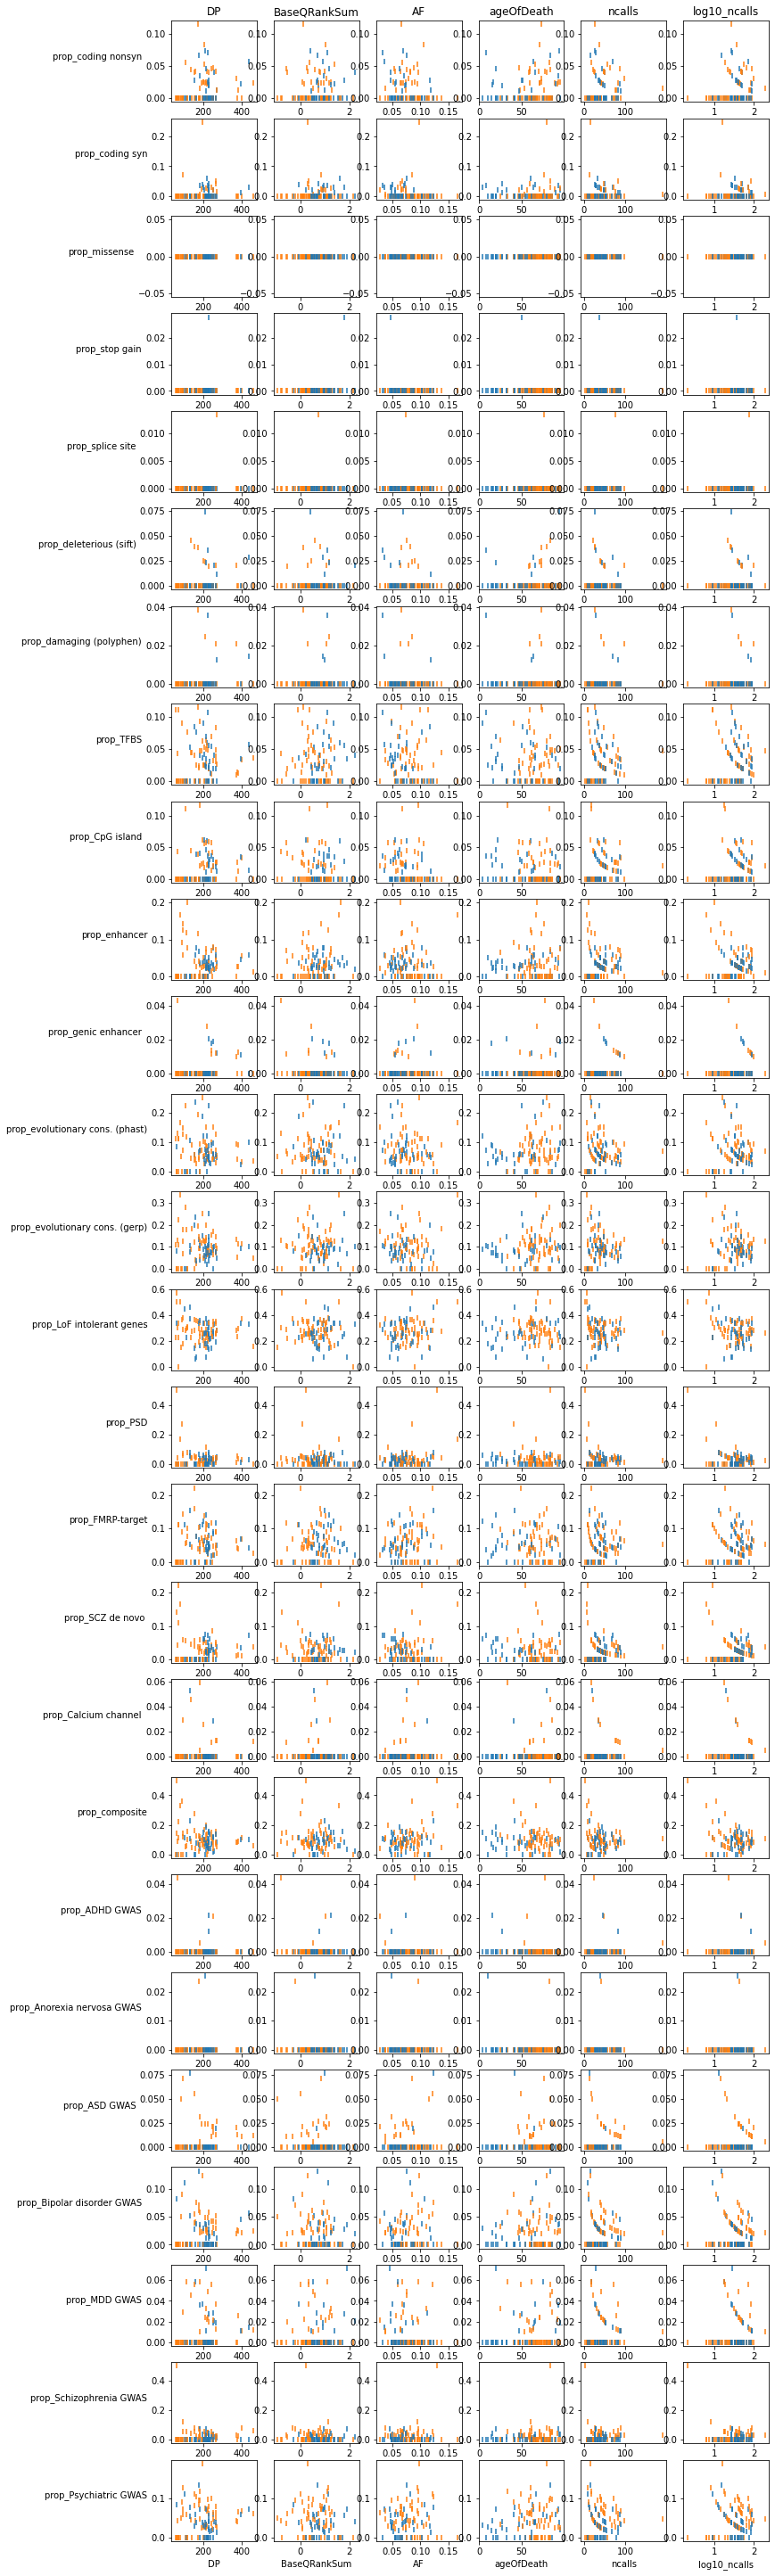

In [24]:
fig, ax = icm.big_plot_matrix(responses_prop_scz, covariates_scz, getDxcol(fitdata_scz))
attila_utils.savefig(fig, 'prop_calls-func-categ-predictors_scz')

## Training data for fitting models

First simplify column names and create data matrix

In [25]:
def endog_binomial(feature, fitdata=fitdata, proportion=False):
    success = fitdata[feature]
    if proportion:
        prop = success / fitdata['ncalls']
        return(prop)
    failure = fitdata['ncalls'] - success
    complement = 'NOT_' + feature
    df = pd.DataFrame({feature: success, complement: failure})
    return(df)

## `scz_gwas_genes`: log linear (Poisson) models

These models are fitted on the count type response: the number of calls within a functional category.  The genome wide number of calls `ncalls` enters the regression model as a covariate

['named-figure/scz_gwas_genes-log10_ncalls-poisson-fit.png',
 'named-figure/scz_gwas_genes-log10_ncalls-poisson-fit.pdf']

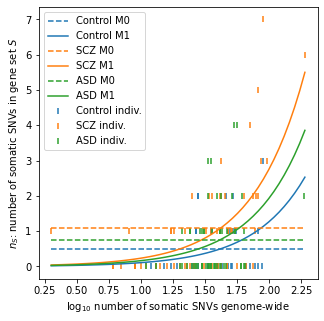

In [26]:
def get_Dxd(fitdata):
    A = {'Control': (0, 0), 'SCZ': (1, 0), 'ASD': (0, 1)}
    B = {'Control': (0,), 'SCZ': (1,)}
    Dxd = A if 'ASD' in fitdata['Dx'].cat.categories else B
    return(Dxd)

def poisson_plot(fitdata):
    formula0 = 'Q("Schizophrenia GWAS") ~ Dx'
    y0, X0 = patsy.dmatrices(formula0, data=fitdata, return_type='dataframe')
    pois0 = sm.GLM(endog=y0, exog=X0, family=sm.families.Poisson()).fit()
    formula1 = 'Q("Schizophrenia GWAS") ~ Dx + log10_ncalls'
    y1, X1 = patsy.dmatrices(formula1, data=fitdata, return_type='dataframe')
    pois1 = sm.GLM(endog=y1, exog=X1, family=sm.families.Poisson()).fit()
    fig, ax = plt.subplots(figsize=(5, 5))
    left = fitdata['log10_ncalls'].min()
    right = fitdata['log10_ncalls'].max()
    log10_ncalls_test = np.linspace(left, right)
    Dxd = get_Dxd(fitdata)
    l = ['C' + str(x) for x in range(len(fitdata['Dx'].cat.categories))]
    for color, Dx in zip(l, fitdata['Dx'].cat.categories):
        y0_pred = pois0.predict([1, *Dxd[Dx]])
        ax.plot([left, right], [y0_pred] * 2, linestyle='dashed', label=Dx + ' M0')
        X_test = pd.DataFrame(dict(zip(X1.columns, [1, *Dxd[Dx], log10_ncalls_test])))
        ax.scatter(x='log10_ncalls', y='Schizophrenia GWAS', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', color=color, label=Dx + ' indiv.')
        ax.plot(log10_ncalls_test, pois1.predict(X_test), color=color, label=Dx + ' M1')
    ax.legend()
    matplotlib.rcParams['text.usetex'] = True
    ax.set_xlabel('$\log_{10}$ number of somatic SNVs genome-wide')
    ax.set_ylabel('$n_S$: number of somatic SNVs in gene set $S$')
    matplotlib.rcParams['text.usetex'] = False
    return((fig, ax))

fig, ax = poisson_plot(fitdata)
attila_utils.savefig(fig, 'scz_gwas_genes-log10_ncalls-poisson-fit')

Now without ASD

['named-figure/scz_gwas_genes-log10_ncalls-poisson-fit_scz.png',
 'named-figure/scz_gwas_genes-log10_ncalls-poisson-fit_scz.pdf']

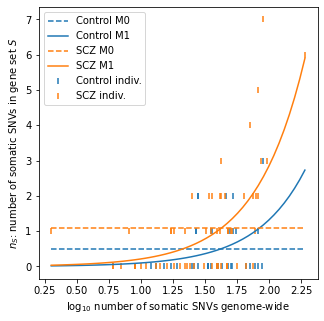

In [27]:
fig, ax = poisson_plot(fitdata_scz)
attila_utils.savefig(fig, 'scz_gwas_genes-log10_ncalls-poisson-fit_scz')

## `scz_gwas_genes`: logistic (binomial) models


In [28]:
y = endog_binomial('Schizophrenia GWAS', fitdata_scz, proportion=True)
formulas = ['Dx', 'Dx + DP', 'Dx + ageOfDeath', 'Dx + Dataset']
def helper(fm):
    X = patsy.dmatrix(fm, data=fitdata_scz, return_type='dataframe')
    mod = sm.GLM(endog=y, exog=X, family=sm.families.Binomial(), var_weights=fitdata_scz['ncalls']).fit()
    return(mod)

binoms = {fm: helper(fm) for fm in formulas}
pvalues = {f: m.pvalues['Dx[T.SCZ]'] for f, m in binoms.items()}
pvalues

{'Dx': 0.001878123731905144,
 'Dx + DP': 0.001903321883367065,
 'Dx + ageOfDeath': 0.010603115322797492,
 'Dx + Dataset': 0.00996672245654694}

In [29]:
params = {f: m.params['Dx[T.SCZ]'] for f, m in binoms.items()}
params

{'Dx': 0.7997476373231286,
 'Dx + DP': 0.7989001461527583,
 'Dx + ageOfDeath': 0.7095657937699092,
 'Dx + Dataset': 0.8803083698988863}

In [30]:
params_SE = {f: m.bse['Dx[T.SCZ]'] for f, m in binoms.items()}
params_SE

{'Dx': 0.25724809712597363,
 'Dx + DP': 0.25730158041264506,
 'Dx + ageOfDeath': 0.2776607157029369,
 'Dx + Dataset': 0.34160443084023245}

The function below was taken from [here](https://gist.github.com/wiso/ce2a9919ded228838703c1c7c7dad13b).

In [31]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

correlation_from_covariance(binoms['Dx + DP'].cov_params())

,Intercept,Dx[T.SCZ],DP
Intercept,1.000000,-0.506596,-0.805924
Dx[T.SCZ],-0.506596,1.000000,-0.013739
DP,-0.805924,-0.013739,1.000000


In [32]:
correlation_from_covariance(binoms['Dx + ageOfDeath'].cov_params())

,Intercept,Dx[T.SCZ],ageOfDeath
Intercept,1.000000,-0.167812,-0.811817
Dx[T.SCZ],-0.167812,1.000000,-0.376125
ageOfDeath,-0.811817,-0.376125,1.000000


In [33]:
correlation_from_covariance(binoms['Dx + Dataset'].cov_params())

,Intercept,Dx[T.SCZ],Dataset[T.Walsh]
Intercept,1.000000,-0.930925,-0.706744
Dx[T.SCZ],-0.930925,1.000000,0.657926
Dataset[T.Walsh],-0.706744,0.657926,1.000000


In [34]:
correlations = {'Dx': 0}
correlations.update({fm: np.abs(correlation_from_covariance(binoms[fm].cov_params()).iloc[1, 2]) for fm in formulas[1:]})
correlations

{'Dx': 0,
 'Dx + DP': 0.013739373223739715,
 'Dx + ageOfDeath': 0.37612498018244983,
 'Dx + Dataset': 0.6579260153135105}

['named-figure/collinearity_Dx_Dataset_ageOfDeath_scz.png',
 'named-figure/collinearity_Dx_Dataset_ageOfDeath_scz.pdf']

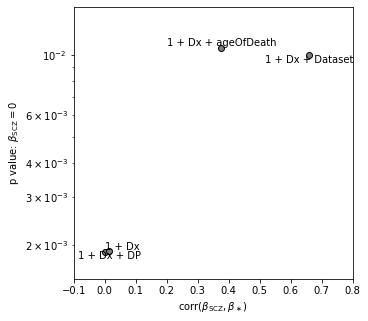

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x=list(correlations.values()), y=list(pvalues.values()), marker='o', color='gray', edgecolors='k')
for x, y, f, v, h in zip(correlations.values(), pvalues.values(), formulas, ['bottom', 'top', 'bottom', 'top'], ['left', 'center', 'center', 'center']):
    ax.annotate(text='1 + ' + f, xy=(x, y), horizontalalignment=h, verticalalignment=v)
ax.set_xlim(-0.1, 0.8)
ax.set_ylim(1.5e-3, 1.5e-2)
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{corr}(\\beta_\mathrm{SCZ}, \\beta_\\ast)$')
ax.set_ylabel('p value: $\\beta_\mathrm{SCZ} = 0$')
attila_utils.savefig(fig, 'collinearity_Dx_Dataset_ageOfDeath_scz')

['named-figure/Dx_Dataset_ageOfDeath.png',
 'named-figure/Dx_Dataset_ageOfDeath.pdf']

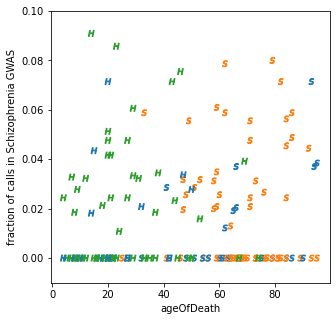

In [36]:
def plot_datasets(responses=responses_prop, covariates=covariates):
    df = pd.concat([responses, covariates], axis=1)
    df['color'] = df.Dx.cat.rename_categories(dict(zip(df.Dx.cat.categories, ['C0', 'C1', 'C2'][:len(df.Dx.cat.categories)])))
    df['Dataset_annot'] = df.Dx.cat.rename_categories(dict(zip(df.Dataset.cat.categories, ['m', 'h'])))
    fig, ax = plt.subplots(figsize=(5, 5))
    for Dataset, marker in zip(covariates.Dataset.cat.categories, ['$S$', '$H$']):
        ds = df.loc[covariates.Dataset == Dataset]
        colors = ds.Dx
        ax.scatter(x='ageOfDeath', y='prop_Schizophrenia GWAS', marker=marker, color=ds['color'], data=ds, label=Dataset)
    ax.set_ylim([-0.01, 0.10])
    ax.set_ylabel('fraction of calls in Schizophrenia GWAS')
    ax.set_xlabel('ageOfDeath')
    #ax.legend()
    return((fig, ax))

fig, ax = plot_datasets(responses=responses_prop, covariates=covariates)
attila_utils.savefig(fig, 'Dx_Dataset_ageOfDeath')

['named-figure/Dx_Dataset_ageOfDeath_scz.png',
 'named-figure/Dx_Dataset_ageOfDeath_scz.pdf']

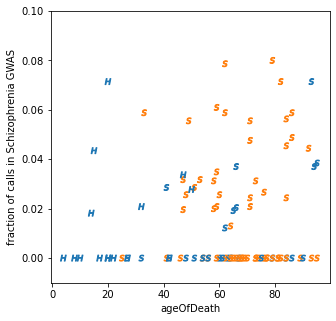

In [37]:
fig, ax = plot_datasets(responses=responses_prop_scz, covariates=covariates_scz)
attila_utils.savefig(fig, 'Dx_Dataset_ageOfDeath_scz')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels.pdf']

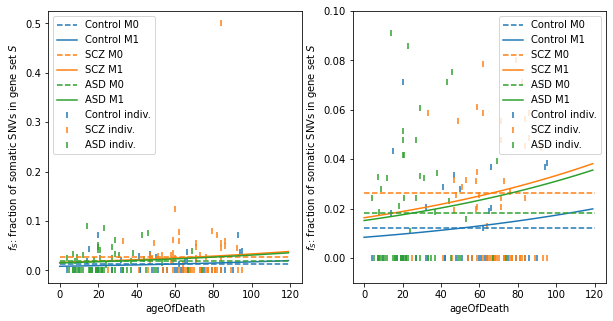

In [38]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

def binom_fit_plot(fig, ax, fitdata):
    y = endog_binomial('Schizophrenia GWAS', fitdata, proportion=True)
    formula0 = 'Dx'
    X0 = patsy.dmatrix(formula0, data=fitdata, return_type='dataframe')
    formula1 = 'Dx + ageOfDeath'
    X1 = patsy.dmatrix(formula1, data=fitdata, return_type='dataframe')
    binom0 = sm.GLM(endog=y, exog=X0, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
    binom1 = sm.GLM(endog=y, exog=X1, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
    left = 0
    right = 120
    X_train = patsy.dmatrix(formula1, data=fitdata, return_type='dataframe')
    ageOfDeath_test = np.arange(0, 120)
    proportion = icm.endog_binomial('Schizophrenia GWAS', fitdata, proportion=True)
    l = ['C' + str(x) for x in range(len(fitdata['Dx'].cat.categories))]
    Dxd = get_Dxd(fitdata)
    for color, Dx in zip(l, fitdata['Dx'].cat.categories):
        y0_pred = binom0.predict([1, *Dxd[Dx]])
        X_test = pd.DataFrame(dict(zip(X_train.columns, [1, *Dxd[Dx], ageOfDeath_test])))
        def myplot(ax):
            ax.scatter(y=proportion.loc[fitdata['Dx'] == Dx], x=fitdata.loc[fitdata['Dx'] == Dx, 'ageOfDeath'], marker='|', color=color, label=Dx + ' indiv.')
            ax.plot([left, right], [y0_pred] * 2, linestyle='dashed', label=Dx + ' M0')
            ax.plot(ageOfDeath_test, binom1.predict(X_test), color=color, label=Dx + ' M1')
            matplotlib.rcParams['text.usetex'] = True
            ax.set_ylabel('$\log_{10} \#\mathrm{calls}$')
            ax.set_ylabel('$f_S$: fraction of somatic SNVs in gene set $S$')
            ax.set_xlabel('ageOfDeath')
            matplotlib.rcParams['text.usetex'] = False
            ax.legend()
            return(ax)
        for axi in fig.axes:
            myplot(axi)
    return(fig, ax)

fig, ax = binom_fit_plot(fig, ax, fitdata)
fig.axes[1].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit-2panels')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels_scz.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels_scz.pdf']

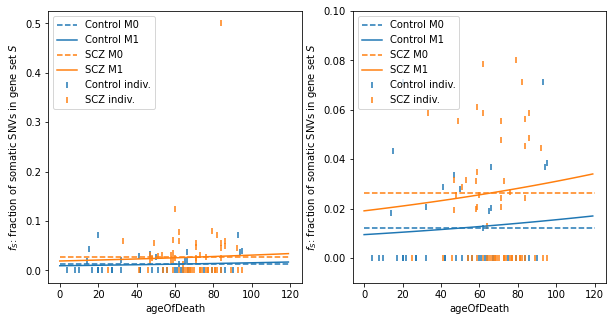

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig, ax = binom_fit_plot(fig, ax, fitdata_scz)
fig.axes[1].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit-2panels_scz')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit.pdf']

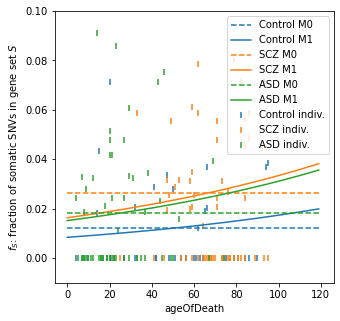

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig, ax = binom_fit_plot(fig, ax, fitdata)
fig.axes[0].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit_scz.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit_scz.pdf']

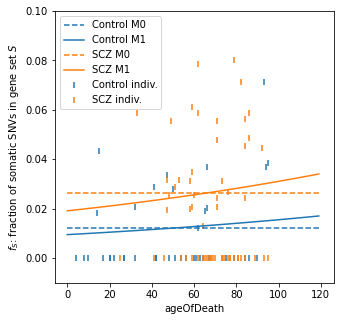

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig, ax = binom_fit_plot(fig, ax, fitdata_scz)
fig.axes[0].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit_scz')

## `Schizophrenia GWAS`: model selection

The partial residual plots reveal that the biggest outlier is actually an SCZ individual CMC_MSSM_201 with only one calls in SCZ GWAS and two calls genome wide.

In [42]:
exogs = ['log10_ncalls', 'Dx', 'ageOfDeath', 'BaseQRankSum', 'Dataset', 'AF', 'DP', 'Gender']
pois_modsel = icm.multifit(fitdata, 'Schizophrenia GWAS', exogs, sm.families.Poisson(), do_fwsel=True)
exogs.remove('log10_ncalls')
binom_modsel = icm.multifit(fitdata, 'Schizophrenia GWAS', exogs, sm.families.Binomial(), do_fwsel=True)

Now repeat after removing all ASD individuals

In [43]:
exogs = ['log10_ncalls', 'Dx', 'ageOfDeath', 'BaseQRankSum', 'Dataset', 'AF', 'DP', 'Gender']
pois_modsel_scz = icm.multifit(fitdata_scz, 'Schizophrenia GWAS', exogs, sm.families.Poisson(), do_fwsel=True)
exogs.remove('log10_ncalls')
binom_modsel_scz = icm.multifit(fitdata_scz, 'Schizophrenia GWAS', exogs, sm.families.Binomial(), do_fwsel=True)

['named-figure/scz_gwas_genes-fw-varsel-pois.png',
 'named-figure/scz_gwas_genes-fw-varsel-pois.pdf']

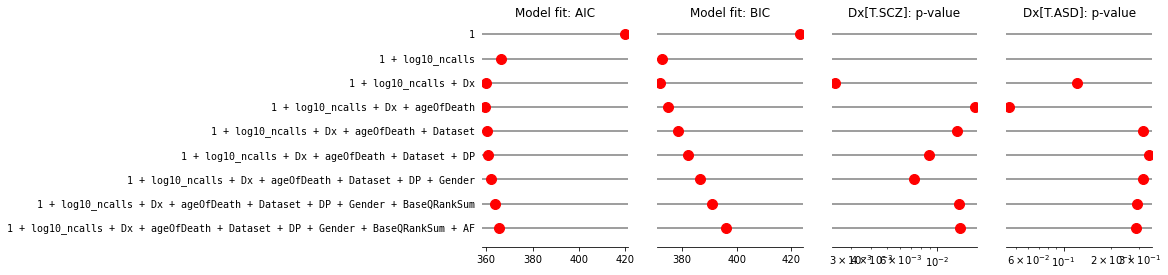

In [44]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(pois_modsel, only_scz=False)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-pois')

['named-figure/scz_gwas_genes-fw-varsel-pois_scz.png',
 'named-figure/scz_gwas_genes-fw-varsel-pois_scz.pdf']

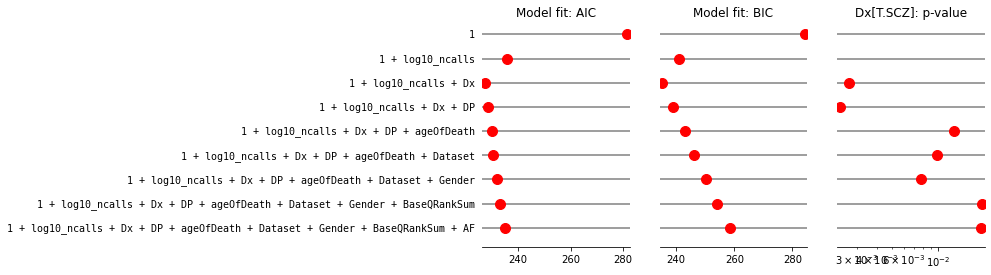

In [45]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(pois_modsel_scz, only_scz=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-pois_scz')

['named-figure/scz_gwas_genes-fw-varsel-pois-onlyIC.png',
 'named-figure/scz_gwas_genes-fw-varsel-pois-onlyIC.pdf']

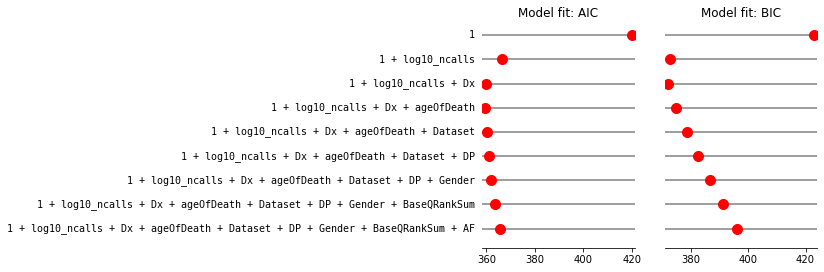

In [46]:
fig, ax = icm.modsel_dotplot(pois_modsel, onlyIC=True, only_scz=False)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-pois-onlyIC')

['named-figure/scz_gwas_genes-fw-varsel-pois-onlyIC_scz.png',
 'named-figure/scz_gwas_genes-fw-varsel-pois-onlyIC_scz.pdf']

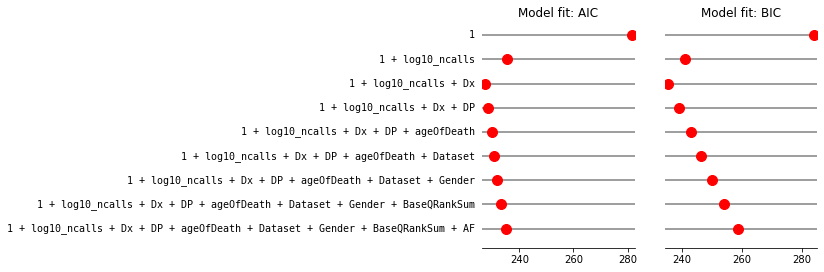

In [47]:
fig, ax = icm.modsel_dotplot(pois_modsel_scz, onlyIC=True, only_scz=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-pois-onlyIC_scz')

['named-figure/scz_gwas_genes-fw-varsel-binom.png',
 'named-figure/scz_gwas_genes-fw-varsel-binom.pdf']

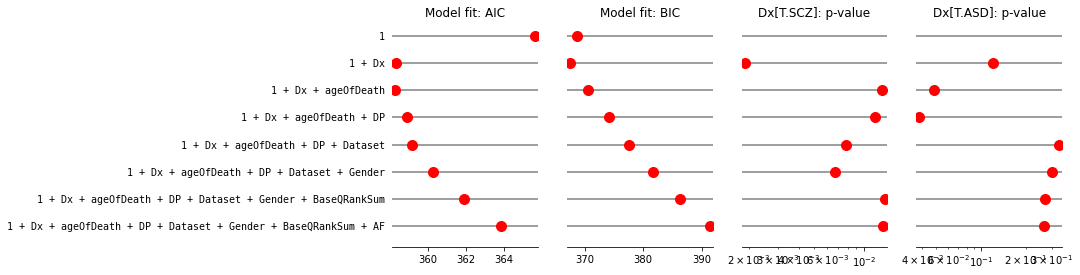

In [48]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(binom_modsel)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-binom')

['named-figure/scz_gwas_genes-fw-varsel-binom_scz.png',
 'named-figure/scz_gwas_genes-fw-varsel-binom_scz.pdf']

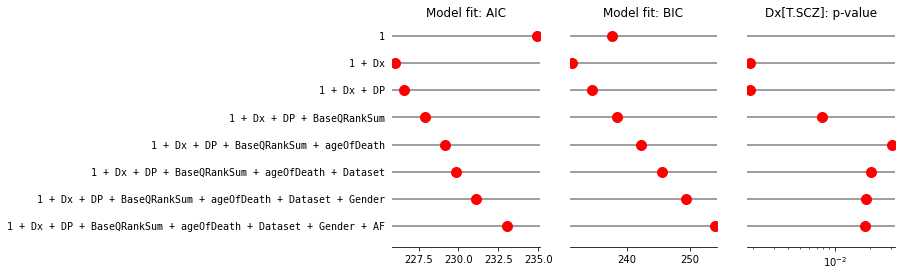

In [49]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(binom_modsel_scz, only_scz=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-binom_scz')

['named-figure/scz_gwas_genes-fw-varsel-binom-onlyIC.png',
 'named-figure/scz_gwas_genes-fw-varsel-binom-onlyIC.pdf']

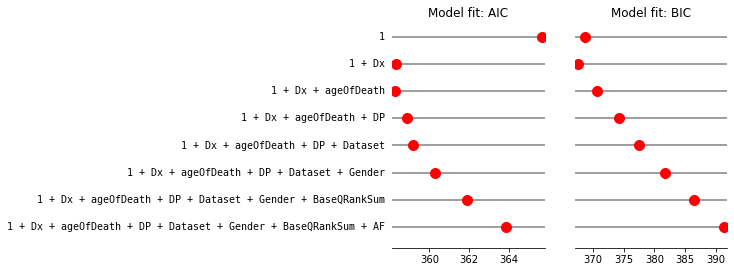

In [50]:
fig, ax = icm.modsel_dotplot(binom_modsel, onlyIC=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-binom-onlyIC')

['named-figure/scz_gwas_genes-fw-varsel-binom-onlyIC_scz.png',
 'named-figure/scz_gwas_genes-fw-varsel-binom-onlyIC_scz.pdf']

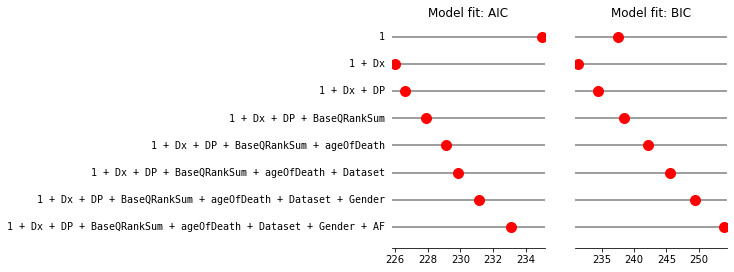

In [51]:
fig, ax = icm.modsel_dotplot(binom_modsel_scz, onlyIC=True, only_scz=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-binom-onlyIC_scz')

## All functional categories: model selection

Below are the results of forward variable selection given each functional category and each model family (Poisson, binomial).  `nindiv | ncalls_f > 0` is the number of individuals with at least one somatic variant call in the given functional category.  More such individuals means more observations to fit the models onto and therefore more complex models are supported by those data sets.  Note the good agreement between the Poisson and binomial models.

In [52]:
endogs = responses.columns
def safely_fit(endog, exogs, family, only_scz=False):
    fitd = fitdata_scz if only_scz else fitdata
    if fitd[endog].value_counts()[1:].sum() < 3:
        return((None, None))
    try:
        modsel = icm.multifit(fitd, endog, exogs, family, do_fwsel=True)
        sel_formula = pd.Series(modsel).apply(lambda m: m.aic).sort_values().index[0]
        val = (sel_formula, modsel[sel_formula])
    except ValueError:
        val = ((None, None))
    return(val)

exogs = ['log10_ncalls', 'Dx', 'BaseQRankSum', 'AF', 'DP', 'Gender']
#exogs = ['log10_ncalls', 'Dx', 'ageOfDeath', 'BaseQRankSum', 'Dataset', 'AF', 'DP']
pois_varsel = {endog: safely_fit(endog, exogs, sm.families.Poisson(), only_scz=False) for endog in endogs}
pois_varsel_scz = {endog: safely_fit(endog, exogs, sm.families.Poisson(), only_scz=True) for endog in endogs}

In [53]:
exogs.remove('log10_ncalls')
binom_varsel = {endog: safely_fit(endog, exogs, sm.families.Binomial(), only_scz=False) for endog in endogs}
binom_varsel_scz = {endog: safely_fit(endog, exogs, sm.families.Binomial(), only_scz=True) for endog in endogs}

In [54]:
def edit_fit_results(d, colname='poisson'):
    l = [pd.Series(d).apply(lambda x: x[i]) for i in [0, 1]]
    columns = pd.MultiIndex.from_product([[colname], ['formula', 'model']])
    df = pd.DataFrame(np.array(l).T, columns=columns, index=d.keys())
    return(df)

varsel = pd.concat([edit_fit_results(d, name) for name, d in zip(['poisson', 'poisson_scz', 'binomial', 'binomial_scz'], [pois_varsel, pois_varsel_scz, binom_varsel, binom_varsel_scz])], axis=1)
varsel['nindiv | ncalls_f > 0'] = responses.apply(lambda x: x.value_counts()[1:].sum(), axis=0)
varsel.iloc[:, ::2]#.sort_values('nindiv | ncalls_f > 0')

,poisson,poisson_scz,binomial,binomial_scz,nindiv | ncalls_f > 0
,formula,formula,formula,formula,
coding nonsyn,1 + log10_ncalls + Dx + BaseQRankSum,1 + log10_ncalls,1 + Dx + BaseQRankSum,1,55
coding syn,1 + log10_ncalls + Gender + AF + Dx,1 + AF + Gender + log10_ncalls,1 + Gender,1 + Gender,38
missense,None,None,None,None,0
stop gain,None,None,None,None,1
splice site,None,None,None,None,1
deleterious (sift),1 + DP,1 + DP,1 + BaseQRankSum,1,19
damaging (polyphen),1 + DP,1 + DP,1 + DP,1 + DP,9
TFBS,1 + log10_ncalls + Dx + AF,1 + log10_ncalls + AF,1 + Dx + AF,1 + AF,93
CpG island,1 + log10_ncalls + Dx + AF,1 + log10_ncalls + AF + BaseQRankSum,1 + Dx + AF,1 + AF + BaseQRankSum,57


## All functional categories: results

The dot plots below show results for the best fitting Poisson (red) and binomial (blue) models across all functional categories.  The regression coefficient estimate for the $j$-th parameter is $\hat{\beta_j}$.  Where the variable corresponding to the $j$-th parameter was not selected by the forward algorithm I present the theoretical null values: 0 for $\beta_j$ and 1 for the $j$-th $p$-value.

For categorical variables these estimates and and $p$-values are complemented by the predicted fold enrichment based on the Poisson models.  The latter is defined as

$$
\mathrm{enrichment} = \exp{\hat{\beta}_j}
$$
since
$$
\hat{\mu} \propto \exp \hat{\eta} = \exp (\hat{\beta}_1 x_1) \dotsm \exp (\hat{\beta}_j x_j) \dotsm \exp (\hat{\beta}_p x_p) \propto \exp \hat{\beta}_j
$$

Here we exploited the property of the exponential function---inverse link function of the Poisson model---that it can be factorized according to $\beta_j x_j$ terms of the linear predictor $\eta = \sum_j \beta_j x_j$.  Such simple definition of enrichment is not possible for the binomial model because its inverse link funtion, the logistic function, is not permissible for similar factorization.  For that recall the definition of the logistic function: $f(x) = e^x / (1 + e^x) = (1 + e^{-x})^{-1}$.

In [55]:
%matplotlib inline

def beta_pval_dotplot(params, pvals, suptitle, do_effsize=True):
    fig, ax = plt.subplots(1, 2 + do_effsize, figsize=(5 * (2 + do_effsize), 5))
    for color, family in zip(['red', 'blue'], params.columns):
        g = dotplots.dot_plot(params[family], lines=params.index, ax=ax[0], marker_props={0:{'color': color}})
        g = dotplots.dot_plot(pvals[family], lines=pvals.index, ax=ax[1], show_names='right', marker_props={0:{'color': color}})
        if do_effsize and family == 'poisson':
            g = dotplots.dot_plot(np.exp(params[family]), lines=params.index, ax=ax[2], show_names='right', marker_props={0:{'color': color}})
            ax[2].set_title('predicted fold enrichment')
    ax[0].set_title('beta')
    ax[1].set_title('p-value')
    ax[1].set_xscale('log')
    fig.suptitle(suptitle)
    return((fig, ax))

betas_SCZ = icm.apply2varsel(lambda m: m.params['Dx[T.SCZ]'], 0, varsel)
beta_se_SCZ = icm.apply2varsel(lambda m: m.bse['Dx[T.SCZ]'], 0, varsel)
pvals_SCZ = icm.apply2varsel(lambda m: m.pvalues['Dx[T.SCZ]'], 1, varsel)
df = pd.concat([betas_SCZ, beta_se_SCZ, pvals_SCZ], axis=1)
df.columns = pd.MultiIndex.from_product([['beta_hat', 'beta_std_err', 'p-value'], ['poisson', 'poisson_scz', 'binomial', 'binomial_scz']])
df
#fig, ax = beta_pval_dotplot(betas_SCZ, pvals_SCZ, 'Dx[T.SCZ]')
#attila_utils.savefig(fig, 'scz-effect-pois-binom')

beta_hat                                     \
                             poisson poisson_scz  binomial binomial_scz   
coding nonsyn               0.381542    0.000000  0.385041     0.000000   
coding syn                 -0.043399    0.000000  0.000000     0.000000   
missense                    0.000000    0.000000  0.000000     0.000000   
stop gain                   0.000000    0.000000  0.000000     0.000000   
splice site                 0.000000    0.000000  0.000000     0.000000   
deleterious (sift)          0.000000    0.000000  0.000000     0.000000   
damaging (polyphen)         0.000000    0.000000  0.000000     0.000000   
TFBS                        0.115969    0.000000  0.100800     0.000000   
CpG island                  0.211536    0.000000  0.219256     0.000000   
enhancer                    0.000000    0.000000  0.000000     0.000000   
genic enhancer              0.000000    0.000000  0.000000     0.000000   
evolutionary cons. (phast)  0.171029    0.184242  0.162124     0.000000   
evolutionary cons. (gerp)   0.308461    0.243893  0.330256     0.240590   
LoF intolerant genes        0.089904    0.000000  0.100340     0.104775   
PSD                         0.000000    0.000000  0.000000     0.000000   
FMRP-target                 0.000000    0.000000  0.000000     0.000000   
SCZ de novo                 0.000000    0.000000  0.000000     0.000000   
Calcium channel             1.114268    1.113114  1.097603     1.097603   
composite                   0.000000    0.000000  0.000000     0.000000   
ADHD GWAS                   0.000000    0.000000  0.000000     0.000000   
Anorexia nervosa GWAS       0.000000    0.000000  0.000000     0.000000   
ASD GWAS                    1.896028    1.898290  1.900558     1.900558   
Bipolar disorder GWAS       0.406686    0.434712  0.410607     0.410607   
MDD GWAS                    0.000000    0.000000  0.000000     0.000000   
Schizophrenia GWAS          0.776819    0.769833  0.799748     0.799748   
Psychiatric GWAS            0.560470    0.562406  0.576538     0.565782   

                           beta_std_err                                     \
                                poisson poisson_scz  binomial binomial_scz   
coding nonsyn                  0.270981    0.000000  0.273309     0.000000   
coding syn                     0.339744    0.000000  0.000000     0.000000   
missense                       0.000000    0.000000  0.000000     0.000000   
stop gain                      0.000000    0.000000  0.000000     0.000000   
splice site                    0.000000    0.000000  0.000000     0.000000   
deleterious (sift)             0.000000    0.000000  0.000000     0.000000   
damaging (polyphen)            0.000000    0.000000  0.000000     0.000000   
TFBS                           0.185627    0.000000  0.186635     0.000000   
CpG island                     0.248302    0.000000  0.247014     0.000000   
enhancer                       0.000000    0.000000  0.000000     0.000000   
genic enhancer                 0.000000    0.000000  0.000000     0.000000   
evolutionary cons. (phast)     0.125888    0.126488  0.129721     0.000000   
evolutionary cons. (gerp)      0.111014    0.106033  0.116125     0.109863   
LoF intolerant genes           0.063291    0.000000  0.072825     0.072746   
PSD                            0.000000    0.000000  0.000000     0.000000   
FMRP-target                    0.000000    0.000000  0.000000     0.000000   
SCZ de novo                    0.000000    0.000000  0.000000     0.000000   
Calcium channel                0.782115    0.782223  0.782381     0.782365   
composite                      0.000000    0.000000  0.000000     0.000000   
ADHD GWAS                      0.000000    0.000000  0.000000     0.000000   
Anorexia nervosa GWAS          0.000000    0.000000  0.000000     0.000000   
ASD GWAS                       0.742230    0.742284  0.742284     0.742284   
Bipolar disorder GWAS          0.227601    0.227649  0.

### Exporting regression results

In [56]:
fpath = '../../results/2021-01-26-indiv-counts-modeling/regression-results.csv'
regres = pd.concat([varsel.loc[:, [('poisson_scz', 'formula'), ('binomial_scz', 'formula')]].swaplevel(0, 1, axis=1),
           df.drop(['poisson', 'binomial'], axis=1, level=1)], axis=1)
regres = regres.rename({'poisson_scz': 'log-linear', 'binomial_scz': 'logistic'}, axis=1).fillna('failed to converge')
regres.to_csv(fpath)

In [57]:
betas_ASD = icm.apply2varsel(lambda m: m.params['Dx[T.ASD]'], 0, varsel)
beta_se_ASD = icm.apply2varsel(lambda m: m.bse['Dx[T.ASD]'], 0, varsel)
pvals_ASD = icm.apply2varsel(lambda m: m.pvalues['Dx[T.ASD]'], 1, varsel)
df = pd.concat([betas_ASD, beta_se_ASD, pvals_ASD], axis=1)
df.columns = pd.MultiIndex.from_product([['beta_hat', 'beta_std_err', 'p-value'], ['poisson', 'poisson_scz', 'binomial', 'binomial_scz']])
df

beta_hat                                     \
                             poisson poisson_scz  binomial binomial_scz   
coding nonsyn              -0.380274           0 -0.381787            0   
coding syn                 -0.709237           0  0.000000            0   
missense                    0.000000           0  0.000000            0   
stop gain                   0.000000           0  0.000000            0   
splice site                 0.000000           0  0.000000            0   
deleterious (sift)          0.000000           0  0.000000            0   
damaging (polyphen)         0.000000           0  0.000000            0   
TFBS                       -0.398125           0 -0.387804            0   
CpG island                 -0.781803           0 -0.795780            0   
enhancer                    0.000000           0  0.000000            0   
genic enhancer              0.000000           0  0.000000            0   
evolutionary cons. (phast) -0.101802           0 -0.123882            0   
evolutionary cons. (gerp)  -0.004746           0 -0.014350            0   
LoF intolerant genes       -0.063994           0 -0.070967            0   
PSD                         0.000000           0  0.000000            0   
FMRP-target                 0.000000           0  0.000000            0   
SCZ de novo                 0.000000           0  0.000000            0   
Calcium channel            -0.335981           0 -0.324109            0   
composite                   0.000000           0  0.000000            0   
ADHD GWAS                   0.000000           0  0.000000            0   
Anorexia nervosa GWAS       0.000000           0  0.000000            0   
ASD GWAS                    0.927860           0  0.930846            0   
Bipolar disorder GWAS      -0.257103           0 -0.258649            0   
MDD GWAS                    0.000000           0  0.000000            0   
Schizophrenia GWAS          0.421651           0  0.424542            0   
Psychiatric GWAS            0.184298           0  0.138086            0   

                           beta_std_err                                     \
                                poisson poisson_scz  binomial binomial_scz   
coding nonsyn                  0.296267           0  0.297958            0   
coding syn                     0.375053           0  0.000000            0   
missense                       0.000000           0  0.000000            0   
stop gain                      0.000000           0  0.000000            0   
splice site                    0.000000           0  0.000000            0   
deleterious (sift)             0.000000           0  0.000000            0   
damaging (polyphen)            0.000000           0  0.000000            0   
TFBS                           0.210141           0  0.210963            0   
CpG island                     0.312472           0  0.311689            0   
enhancer                       0.000000           0  0.000000            0   
genic enhancer                 0.000000           0  0.000000            0   
evolutionary cons. (phast)     0.135789           0  0.141414            0   
evolutionary cons. (gerp)      0.113253           0  0.119301            0   
LoF intolerant genes           0.069353           0  0.076211            0   
PSD                            0.000000           0  0.000000            0   
FMRP-target                    0.000000           0  0.000000            0   
SCZ de novo                    0.000000           0  0.000000            0   
Calcium channel                1.000254           0  1.000522            0   
composite                      0.000000           0  0.000000            0   
ADHD GWAS                      0.000000           0  0.000000            0   
Anorexia nervosa GWAS          0.000000           0  0.000000            0   
ASD GWAS                       0.801925           0  0.802419            0   
Bipolar disorder GWAS          0.262885           0  0.

In [58]:
def merge_model_chisq(modeldfs=[pvals_SCZ, pvals_ASD], family='binomial', summary_chisq=summary_chisq):
    l = [df[family] for df in modeldfs]
    df = pd.DataFrame(pd.concat(l, axis=1).to_numpy(), columns=['Dx[T.SCZ]', 'Dx[T.ASD]'])
    df.index = pvals_SCZ.index
    s = summary_chisq['chisq p']
    s.index = df.index
    df['chi^2'] = s
    return(df)

binom_chisq_pvals = merge_model_chisq([pvals_SCZ, pvals_ASD], family='binomial', summary_chisq=summary_chisq)
binom_chisq_pvals_scz = merge_model_chisq([pvals_SCZ, pvals_ASD], family='binomial_scz', summary_chisq=summary_chisq_scz)
binom_chisq_pvals

,Dx[T.SCZ],Dx[T.ASD],chi^2
coding nonsyn,0.158890,0.200072,0.106440
coding syn,1.000000,1.000000,0.554924
missense,1.000000,1.000000,NaN
stop gain,1.000000,1.000000,0.236044
splice site,1.000000,1.000000,0.453210
deleterious (sift),1.000000,1.000000,0.518131
damaging (polyphen),1.000000,1.000000,0.582566
TFBS,0.589132,0.066025,0.127453
CpG island,0.374741,0.010676,0.008169
enhancer,1.000000,1.000000,0.293081


In [59]:
binom_chisq_pvals_scz

,Dx[T.SCZ],Dx[T.ASD],chi^2
coding nonsyn,1.000000,1.0,0.400373
coding syn,1.000000,1.0,0.579184
missense,1.000000,1.0,NaN
stop gain,1.000000,1.0,0.219882
splice site,1.000000,1.0,0.415015
deleterious (sift),1.000000,1.0,0.547703
damaging (polyphen),1.000000,1.0,0.888940
TFBS,1.000000,1.0,0.676118
CpG island,1.000000,1.0,0.452985
enhancer,1.000000,1.0,0.842884


### Multiple test correction

Below are the hypotheses that are rejected after multiple test correction with
* various methods such as `fdr_bh`, the classic Benjamini-Hochberg procedure
* various model family such as $\chi^2$ and binomial-logistic
* various size $\alpha$ for FDR

In [60]:
def do_fdr(method, alpha, test='chi^2'):
    val = sm.stats.multipletests(binom_chisq_pvals_scz[test], alpha=alpha, method=method)
    res = list(binom_chisq_pvals_scz.index[val[0]])
    return(res)

def get_fdr_rejected(test):
    fdr_methods = ['fdr_bh', 'fdr_tsbh', 'fdr_tsbky', 'holm-sidak', 'bonferroni']
    fdr_rejected = {alpha: [do_fdr(method, alpha, test) for method in fdr_methods] for alpha in alphas}
    fdr_rejected = pd.DataFrame(fdr_rejected, index=fdr_methods)
    return(fdr_rejected)

alphas = [0.05, 0.025, 0.01]
fdr_rejected = pd.concat([get_fdr_rejected(test) for test in ['chi^2', 'Dx[T.SCZ]']], axis=1)
fdr_rejected.columns = pd.MultiIndex.from_product([['chi^2', 'logistic'], alphas])
fdr_rejected

chi^2  \
                                                       0.050   
fdr_bh      [ASD GWAS, Schizophrenia GWAS, Psychiatric GWAS]   
fdr_tsbh    [ASD GWAS, Schizophrenia GWAS, Psychiatric GWAS]   
fdr_tsbky   [ASD GWAS, Schizophrenia GWAS, Psychiatric GWAS]   
holm-sidak            [Schizophrenia GWAS, Psychiatric GWAS]   
bonferroni            [Schizophrenia GWAS, Psychiatric GWAS]   

                                                          \
                                             0.025 0.010   
fdr_bh      [Schizophrenia GWAS, Psychiatric GWAS]    []   
fdr_tsbh    [Schizophrenia GWAS, Psychiatric GWAS]    []   
fdr_tsbky   [Schizophrenia GWAS, Psychiatric GWAS]    []   
holm-sidak                                      []    []   
bonferroni                                      []    []   

                                          logistic  \
                                             0.050   
fdr_bh      [Schizophrenia GWAS, Psychiatric GWAS]   
fdr_tsbh    [Schizophrenia GWAS, Psychiatric GWAS]   
fdr_tsbky   [Schizophrenia GWAS, Psychiatric GWAS]   
holm-sidak  [Schizophrenia GWAS, Psychiatric GWAS]   
bonferroni  [Schizophrenia GWAS, Psychiatric GWAS]   

                                                          
                                             0.025 0.010  
fdr_bh      [Schizophrenia GWAS, Psychiatric GWAS]    []  
fdr_tsbh    [Schizophrenia GWAS, Psychiatric GWAS]    []  
fdr_tsbky                                       []    []  
holm-sidak                      [Psychiatric GWAS]    []  
bonferroni                      [Psychiatric GWAS]    []

In [61]:
def get_plot_data(family_chisq_pvals=binom_chisq_pvals):
    family_chisq_pvals_rev = family_chisq_pvals.reindex(reversed(family_chisq_pvals.index))
    callsperind = operations.summarize_query_mean_sem(results, data)
    callsperind.index = family_chisq_pvals.index
    callsperind = callsperind.reindex(family_chisq_pvals.index)
    stdcpi = callsperind.sort_values(('Control', 'mean'), ascending=True).apply(lambda x: x / x[('Control', 'mean')], axis=1).dropna()
    stdcpi = stdcpi.reindex(family_chisq_pvals.index)
    stdcpirev = stdcpi.reindex(reversed(stdcpi.index))
    ncalls_tot = pd.Series(summary.sum(axis=1).to_numpy(), index=family_chisq_pvals.index)
    ncalls_tot_rev = ncalls_tot.reindex(reversed(ncalls_tot.index))
    plot_data = (family_chisq_pvals_rev, ncalls_tot_rev, stdcpirev, ncalls_tot_rev)
    return(plot_data)

binom_chisq_pvals_rev, ncalls_tot_rev, stdcpirev, ncalls_tot_rev = get_plot_data(family_chisq_pvals=binom_chisq_pvals)
binom_chisq_pvals_rev_scz, ncalls_tot_rev_scz, stdcpirev_scz, ncalls_tot_rev_scz = get_plot_data(family_chisq_pvals=binom_chisq_pvals_scz)

ticks = np.arange(len(binom_chisq_pvals))
yticklabels = list(reversed(binom_chisq_pvals.index))

## Visualization

['named-figure/enrichment-5-plots.png', 'named-figure/enrichment-5-plots.pdf']

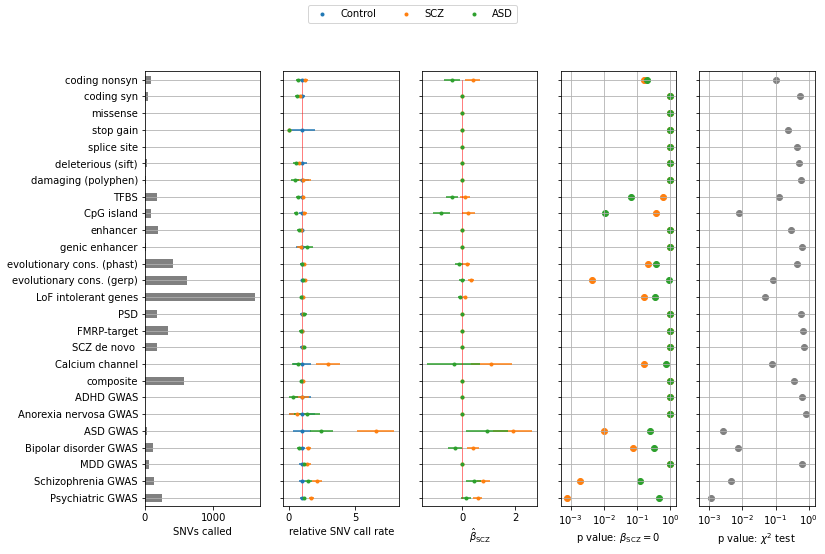

In [62]:
def set_yticklabels(ax, yticks, yticklabels):
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    return(ax)

def pval_scatter_style(ax, yticks, yticklabels):
    ax = set_yticklabels(ax, yticks, yticklabels)
    ax.set_xlim(5e-4, 1.5)
    ax.set_xscale('log')
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0])
    ax.grid(True, axis='both')
    #ax.set_xlabel('p value')
    return(ax)

def ncalls_scatter(ax, ncalls_tot_rev=ncalls_tot_rev):
    ncalls_tot_rev.plot(kind='barh', ax=ax, color='gray')
    ax.grid(True, axis='y')
    ax.set_xlabel('SNVs called')
    return(ax)

def callrates_scatter(ax, stdcpirev=stdcpirev, only_scz=False):
    if only_scz:
        stdcpirev = stdcpirev.drop('ASD', axis=1)
    colors = ['C0', 'C1'] if only_scz else ['C0', 'C1', 'C2']
    x = stdcpirev.xs('mean', level=1, axis=1)
    error = stdcpirev.xs('sem', level=1, axis=1)
    for Dx, color in zip(x, colors):
        ax.errorbar(x[Dx], ticks, xerr=error[Dx], fmt='.', color=color, label=Dx)
    ax.grid(True, axis='y')
    ax.plot([1, 1], [0, ticks[-1]], linestyle='solid', color='red', linewidth=0.5)
    #ax.legend(loc='upper right')
    ax = set_yticklabels(ax, ticks, yticklabels)
    ax.set_xlabel('relative SNV call rate')
    return(ax)

def betas_scatter(ax, stdcpirev=stdcpirev, family='binomial', only_scz=False):
    ax.errorbar(x=betas_SCZ.reindex(stdcpirev.index)[family], y=ticks, xerr=beta_se_SCZ.reindex(stdcpirev.index)[family], fmt='.', color='C1', label='Dx[T.SCZ]')
    #ax.scatter(betas_SCZ.reindex(stdcpirev.index)[family], ticks, color='C1', label='Dx[T.SCZ]')
    if not only_scz:
        ax.errorbar(x=betas_ASD.reindex(stdcpirev.index)[family], y=ticks, xerr=beta_se_ASD.reindex(stdcpirev.index)[family], fmt='.', color='C2', label='Dx[T.ASD]')
        #ax.scatter(betas_ASD.reindex(stdcpirev.index)[family], ticks, color='C2', label='Dx[T.ASD]')
    ax.grid(True, axis='y')
    ax.plot([0, 0], [0, ticks[-1]], linestyle='solid', color='red', linewidth=0.5)
    ax = set_yticklabels(ax, ticks, yticklabels)
    #ax.legend(loc='upper right')
    matplotlib.rcParams['text.usetex'] = True
    ax.set_xlabel('$\hat{\\beta}_\mathrm{SCZ}$')
    matplotlib.rcParams['text.usetex'] = False
    return(ax)

def beta_pval_scatter(ax, family_chisq_pvals_rev=binom_chisq_pvals_rev, only_scz=False):
    levels = ['Dx[T.SCZ]'] if only_scz else ['Dx[T.SCZ]', 'Dx[T.ASD]']
    colors = ['C1'] if only_scz else ['C1', 'C2']
    for term, color in zip(levels, colors):
        ax.scatter(family_chisq_pvals_rev[term], ticks, label=term, color=color)
    #ax.legend()
    matplotlib.rcParams['text.usetex'] = True
    ax.set_xlabel('p value: $\\beta_\mathrm{SCZ} = 0$')
    matplotlib.rcParams['text.usetex'] = False
    ax = pval_scatter_style(ax, ticks, yticklabels)
    return(ax)

def chisq_pval_scatter(ax, family_chisq_pvals_rev=binom_chisq_pvals_rev):
    ax.scatter(family_chisq_pvals_rev['chi^2'], ticks, color='gray')
    matplotlib.rcParams['text.usetex'] = True
    ax.set_xlabel('p value: $\chi^2$ test')
    ax = pval_scatter_style(ax, ticks, yticklabels)
    matplotlib.rcParams['text.usetex'] = False
    return(ax)


def plot5panels(only_scz=False):
    ncalls_tr = ncalls_tot_rev_scz if only_scz else ncalls_tot_rev
    stdcpir = stdcpirev_scz if only_scz else stdcpirev
    fig, ax = plt.subplots(1, 5, figsize=(12, 8), sharey=True, sharex=False)
    family = 'binomial_scz' if only_scz else 'binomial'
    binom_chisq_pvals_r = binom_chisq_pvals_rev_scz if only_scz else binom_chisq_pvals_rev
    ax[0] = ncalls_scatter(ax[0], ncalls_tot_rev=ncalls_tr)
    ax[1] = callrates_scatter(ax[1], stdcpirev=stdcpir, only_scz=only_scz)
    ax[2] = betas_scatter(ax[2], stdcpirev=stdcpir, family=family, only_scz=only_scz)
    ax[3] = beta_pval_scatter(ax[3], family_chisq_pvals_rev=binom_chisq_pvals_r, only_scz=only_scz)
    ax[4] = chisq_pval_scatter(ax[4], family_chisq_pvals_rev=binom_chisq_pvals_r)
    labels = list(covariates_scz.Dx.cat.categories) if only_scz else list(covariates.Dx.cat.categories)
    fig.legend(handles=ax[1].lines[:-1], labels=labels, ncol=3, loc='upper center')
    return((fig, ax))

fig, ax = plot5panels(only_scz=False)
attila_utils.savefig(fig, 'enrichment-5-plots')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['named-figure/enrichment-5-plots_scz.png',
 'named-figure/enrichment-5-plots_scz.pdf']

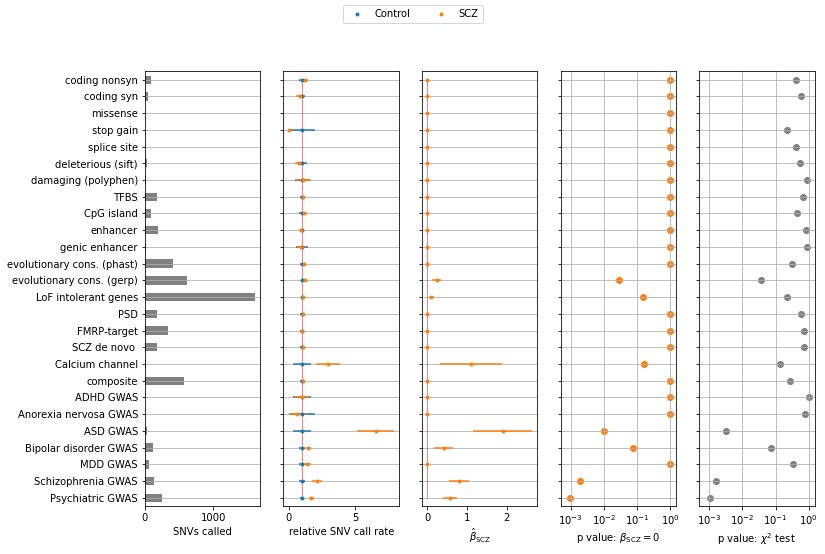

In [63]:
fig, ax = plot5panels(only_scz=True)
attila_utils.savefig(fig, 'enrichment-5-plots_scz')

['named-figure/enrichment-chisq.png', 'named-figure/enrichment-chisq.pdf']

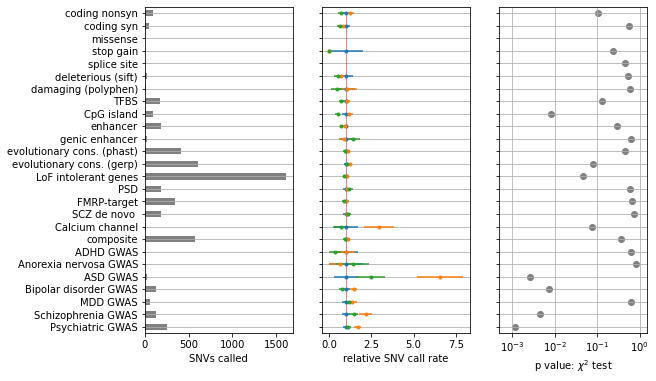

In [64]:
def plot3panels(only_scz=False):
    ncalls_tr = ncalls_tot_rev_scz if only_scz else ncalls_tot_rev
    stdcpir = stdcpirev_scz if only_scz else stdcpirev
    fig, ax = plt.subplots(1, 3, figsize=(9, 6), sharey=True, sharex=False)
    family = 'binomial_scz' if only_scz else 'binomial'
    binom_chisq_pvals_r = binom_chisq_pvals_rev_scz if only_scz else binom_chisq_pvals_rev
    ax[0] = ncalls_scatter(ax[0], ncalls_tot_rev=ncalls_tr)
    ax[1] = callrates_scatter(ax[1], stdcpirev=stdcpir, only_scz=only_scz)
    ax[2] = chisq_pval_scatter(ax[2], family_chisq_pvals_rev=binom_chisq_pvals_r)
    return((fig, ax))

fig, ax = plot3panels(only_scz=False)
attila_utils.savefig(fig, 'enrichment-chisq')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['named-figure/enrichment-chisq_scz.png',
 'named-figure/enrichment-chisq_scz.pdf']

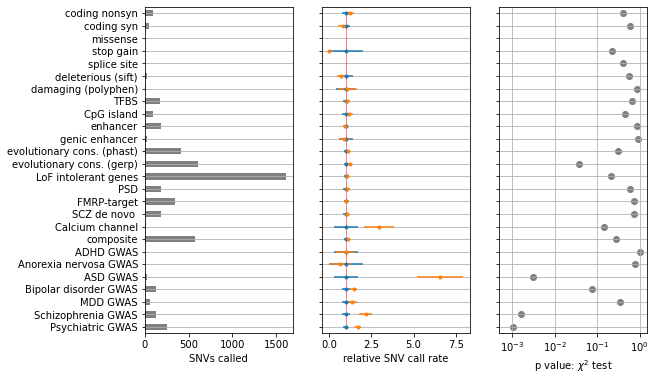

In [65]:
fig, ax = plot3panels(only_scz=True)
attila_utils.savefig(fig, 'enrichment-chisq_scz')

['named-figure/enrichment-model-chisq.png',
 'named-figure/enrichment-model-chisq.pdf']

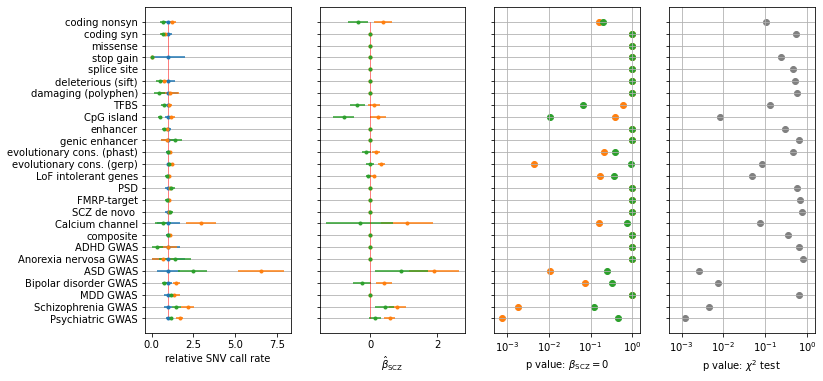

In [66]:
def plot4panels(only_scz=False):
    ncalls_tr = ncalls_tot_rev_scz if only_scz else ncalls_tot_rev
    stdcpir = stdcpirev_scz if only_scz else stdcpirev
    fig, ax = plt.subplots(1, 4, figsize=(12, 6), sharey=True, sharex=False)
    family = 'binomial_scz' if only_scz else 'binomial'
    binom_chisq_pvals_r = binom_chisq_pvals_rev_scz if only_scz else binom_chisq_pvals_rev
    ax[0] = callrates_scatter(ax[0], stdcpirev=stdcpir, only_scz=only_scz)
    ax[1] = betas_scatter(ax[1], stdcpirev=stdcpir, family=family, only_scz=only_scz)
    ax[2] = beta_pval_scatter(ax[2], family_chisq_pvals_rev=binom_chisq_pvals_r, only_scz=only_scz)
    ax[3] = chisq_pval_scatter(ax[3], family_chisq_pvals_rev=binom_chisq_pvals_r)
    return((fig, ax))

plot4panels(only_scz=False)
attila_utils.savefig(fig, 'enrichment-model-chisq')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['named-figure/enrichment-model-chisq_scz.png',
 'named-figure/enrichment-model-chisq_scz.pdf']

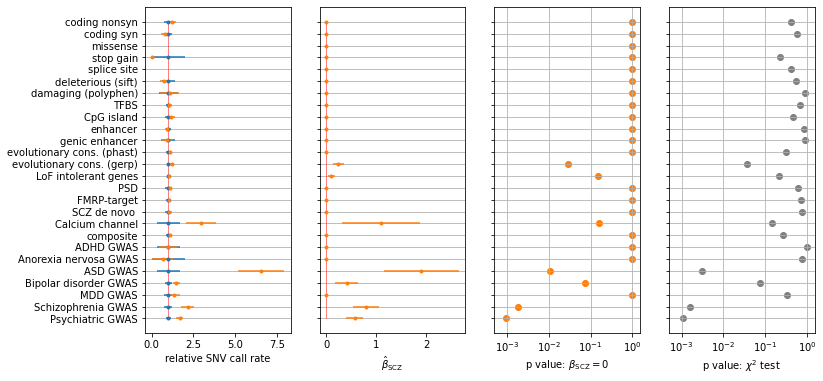

In [67]:
plot4panels(only_scz=True)
attila_utils.savefig(fig, 'enrichment-model-chisq_scz')

['named-figure/age-effect-pois-binom.png',
 'named-figure/age-effect-pois-binom.pdf']

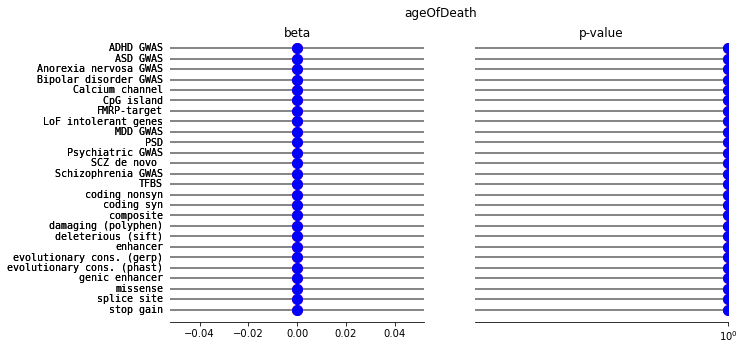

In [68]:
x = icm.apply2varsel(lambda m: m.params['ageOfDeath'], 0, varsel)
y = icm.apply2varsel(lambda m: m.pvalues['ageOfDeath'], 1, varsel)
fig, ax = beta_pval_dotplot(x, y, 'ageOfDeath', False)
attila_utils.savefig(fig, 'age-effect-pois-binom')

## Checking model fit

There are several types of residuals in use for generalized linear models.  The $r^\ast$ residual is approximately normally distributed even if the error distribution for the model family is not normal, such as Poisson or binomial.  This residual is defined (see A.C Davison Statistical Models Ch10.2 p477) as follows
$$
r^\ast = r_\mathrm{D} + r_\mathrm{D}^{-1} \log \frac{r_\mathrm{P}}{r_\mathrm{D}}
$$

['named-figure/binom-four-resid-types.png',
 'named-figure/binom-four-resid-types.pdf']

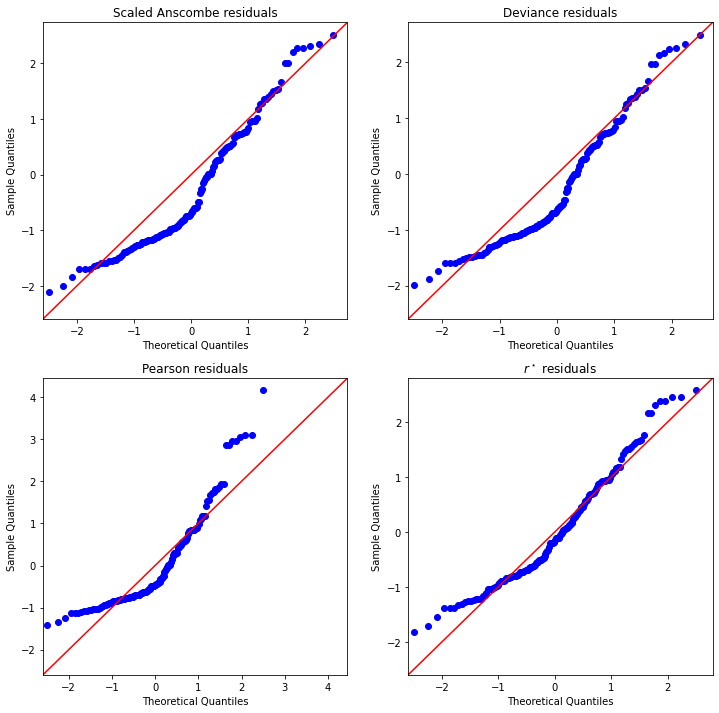

In [69]:
fig, ax = icm.QQ_four_residual_types(varsel.loc['Schizophrenia GWAS', ('binomial', 'model')])
attila_utils.savefig(fig, 'binom-four-resid-types')

['named-figure/binom-four-resid-types_scz.png',
 'named-figure/binom-four-resid-types_scz.pdf']

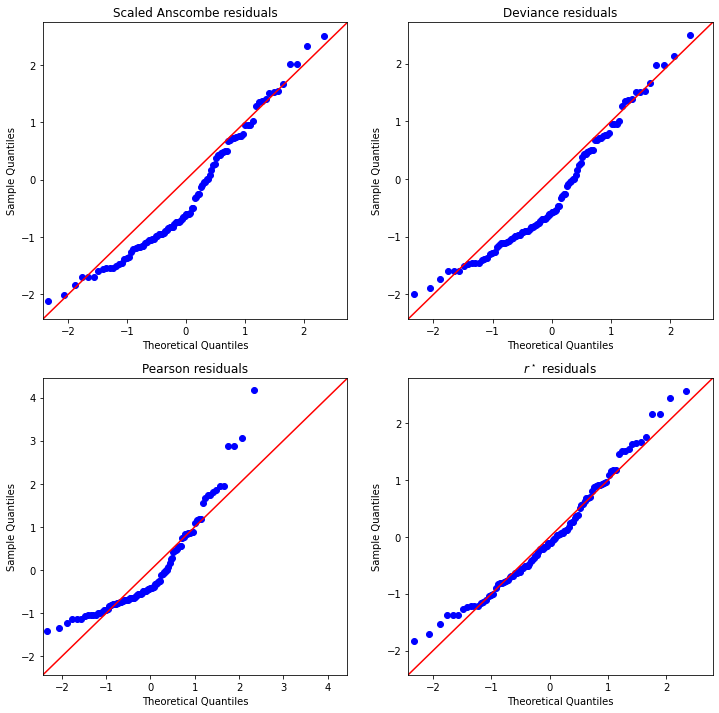

In [70]:
fig, ax = icm.QQ_four_residual_types(varsel.loc['Schizophrenia GWAS', ('binomial_scz', 'model')])
attila_utils.savefig(fig, 'binom-four-resid-types_scz')

The two plot matrices below show that increasing number of non-null observations improve model fit both for the Poisson and the binomial family.  The latter seems to fit the data slightly better.

['named-figure/resid-pois.png', 'named-figure/resid-pois.pdf']

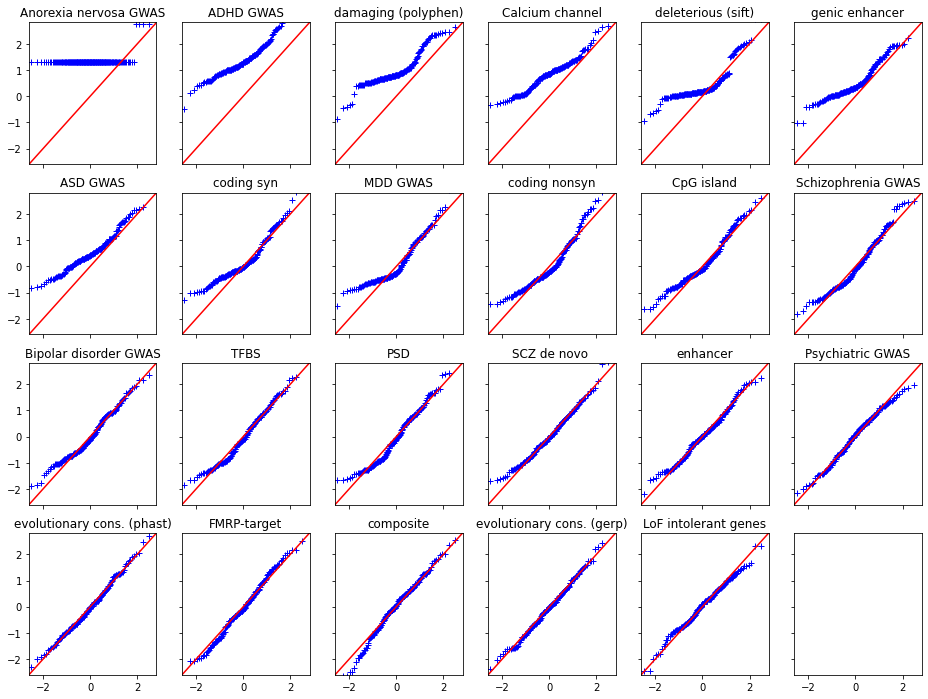

In [71]:
#fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc['deleterious_low_confidence':, ('poisson', 'model')])
first_fitted = 'Anorexia nervosa GWAS'
fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc[first_fitted:, ('poisson', 'model')])
attila_utils.savefig(fig, 'resid-pois')

['named-figure/resid-pois_scz.png', 'named-figure/resid-pois_scz.pdf']

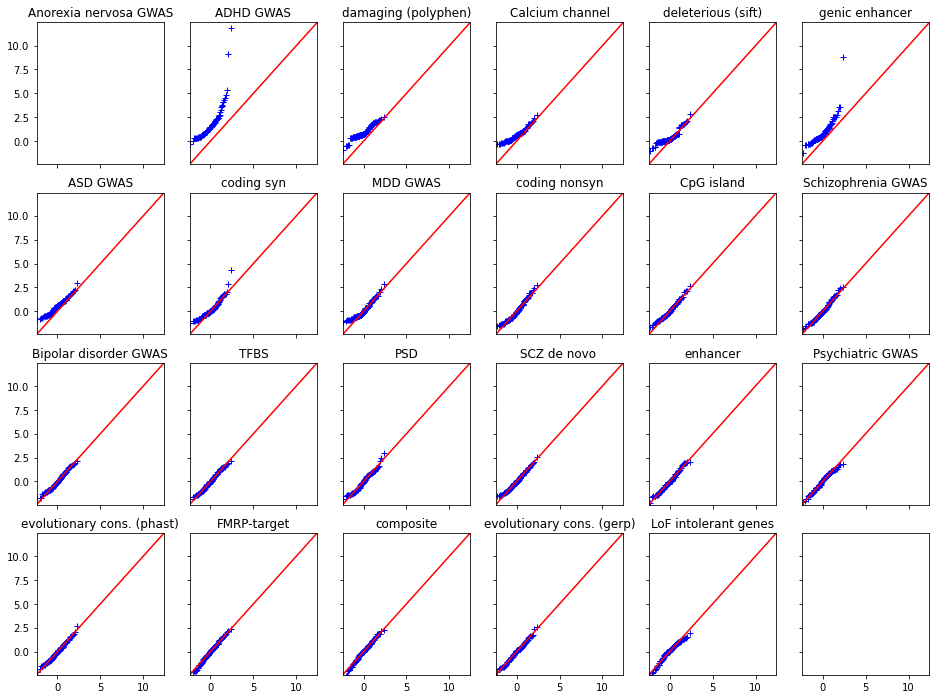

In [72]:
fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc[first_fitted:, ('poisson_scz', 'model')])
attila_utils.savefig(fig, 'resid-pois_scz')

['named-figure/resid-binom.png', 'named-figure/resid-binom.pdf']

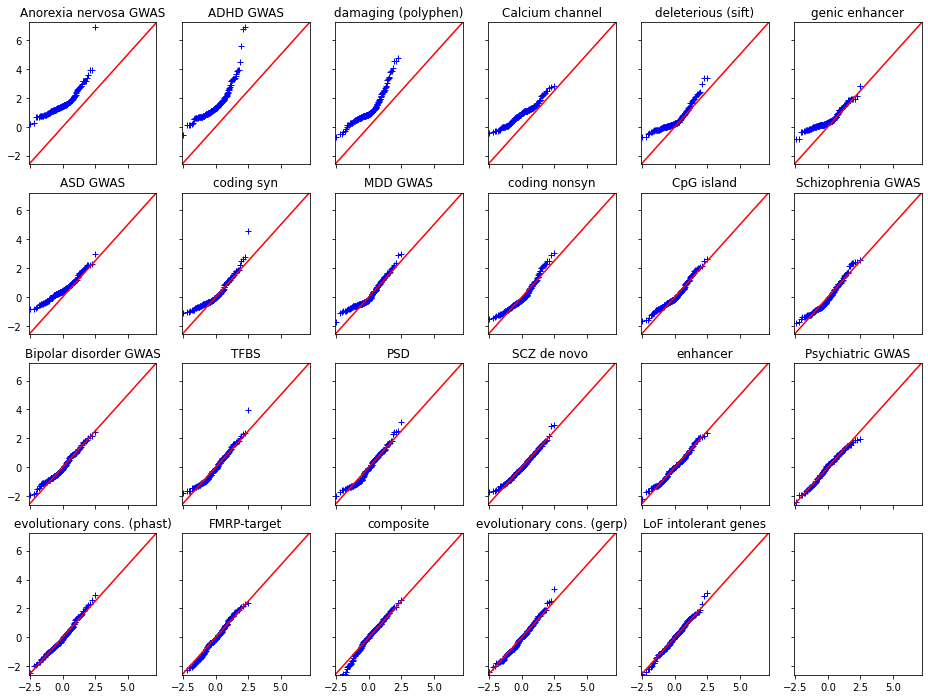

In [73]:
fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc[first_fitted:, ('binomial', 'model')])
attila_utils.savefig(fig, 'resid-binom')

['named-figure/resid-binom_scz.png', 'named-figure/resid-binom_scz.pdf']

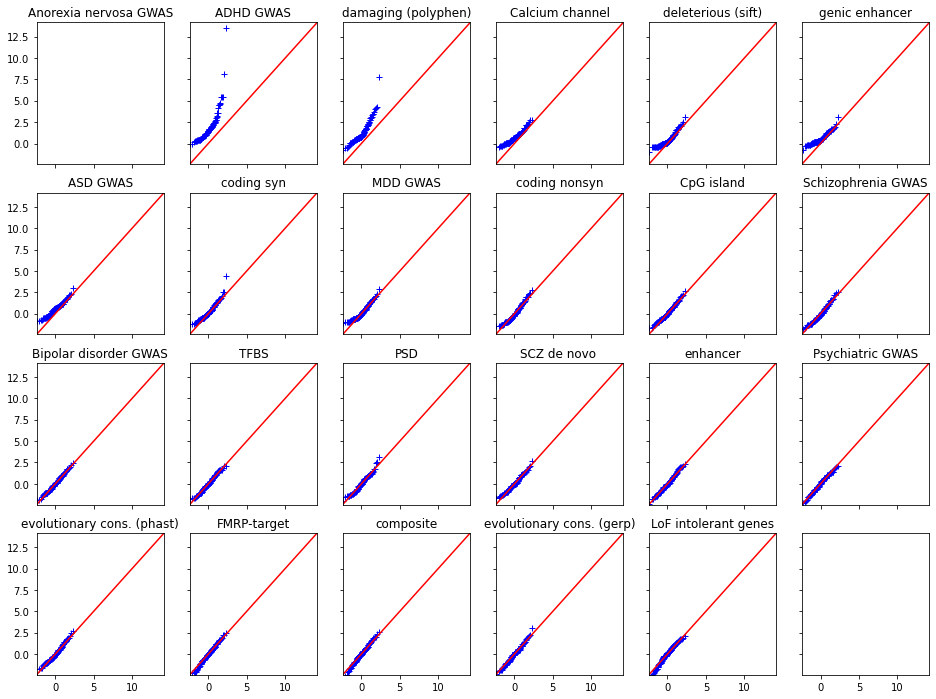

In [74]:
fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc[first_fitted:, ('binomial_scz', 'model')])
attila_utils.savefig(fig, 'resid-binom_scz')

['named-figure/scz_gwas_genes-poisson-partial-resid-plot_scz.png',
 'named-figure/scz_gwas_genes-poisson-partial-resid-plot_scz.pdf']

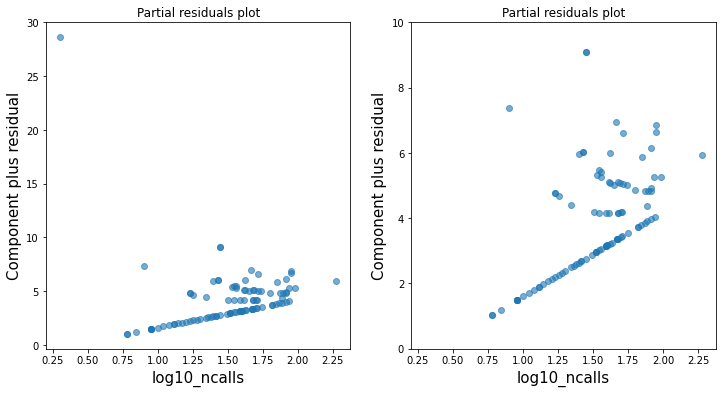

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
m = varsel.loc['Schizophrenia GWAS', ('poisson_scz', 'model')]
g = m.plot_partial_residuals('log10_ncalls', ax=ax[0])
g = m.plot_partial_residuals('log10_ncalls', ax=ax[1])
ax[1].set_ylim(0, 10)
attila_utils.savefig(fig, 'scz_gwas_genes-poisson-partial-resid-plot_scz')

In [76]:
%connect_info

{
  "shell_port": 42305,
  "iopub_port": 43317,
  "stdin_port": 46175,
  "control_port": 51015,
  "hb_port": 47307,
  "ip": "127.0.0.1",
  "key": "a25f3722-fbc3265ac383c95264e55c71",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c6fe3ed1-8ce9-4e00-b4be-79b69570fae2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
